# Introdução

Este trabalho utiliza um banco de dados real e público referente ao uso do sistema público de transporte no município de Teresina. O objetivo é desenvolver um modelo para a previsão de passageiros. Foram desenvolvidos dois modelos para comparar o que possui a melhor capacidade de prever a quantidade de passageiros. O primeiro a ser apresentado pertence aos modelos clássicos de Séries Temporais e outro com o uso de rede neurais.  

O banco de dados apresenta algumas inconsistências que obrigaram a realizar algumas transformações para a análise e desenvolvimento do modelos. De acordo com os problemas que surgirem, utilizaremos algumas técnicas de correção para obter uma análise mais eficiente e usaremos linguagem python e utlizaremos pacotes de acordo com a necessidade da operação

In [1]:
import pandas as pd
import numpy as np
import glob 

from copy import deepcopy as dc

# neural packages
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# statistical packages

from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# graphics packages
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

Construímos duas funções para iniciar o processo de trabalho de análise de dados, a primeira, *files()* tem como objetivo carregar todos os arquivos que iremos trabalhar. Possuímos a limitação que o banco de dados não é conectado a nenhum sistema, como SQL ou algum tipo cloud. Para superar essa dificuldade, realizamos o download considerando um período mensal. 

Ao após a inclusão dos dados, a função construída realiza a união do arquivos num único arquivo para podermos manipular unidos.

A função *pas()* constroi outro arquivo com a quantidade de passageiros diários, que iremos utlizar para realizar a previsão de passageiros.

In [2]:
# função para carregar os data.frames
def files(year): # format YY
    all_files = glob.glob("ano_" + str(year) + "_*.csv")
    df = pd.concat((pd.read_csv(f, encoding='ISO-8859-1', on_bad_lines='skip', sep = ';', decimal = ",") for f in all_files))
    df = df[(df['Tipo Viagem'] == 11)] # eliminando viagens para garagens 
    df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], format='%d/%m/%Y')
    diario = df.groupby('Data Coleta')['Passageiros'].agg('sum')
    diario = diario.reset_index()
    diario['Data Coleta'] = pd.to_datetime(diario['Data Coleta'])
    diario['dia_semana'] = diario['Data Coleta'].dt.dayofweek
    #print(len(diario))
    return(diario)

freq_pas = files(22)

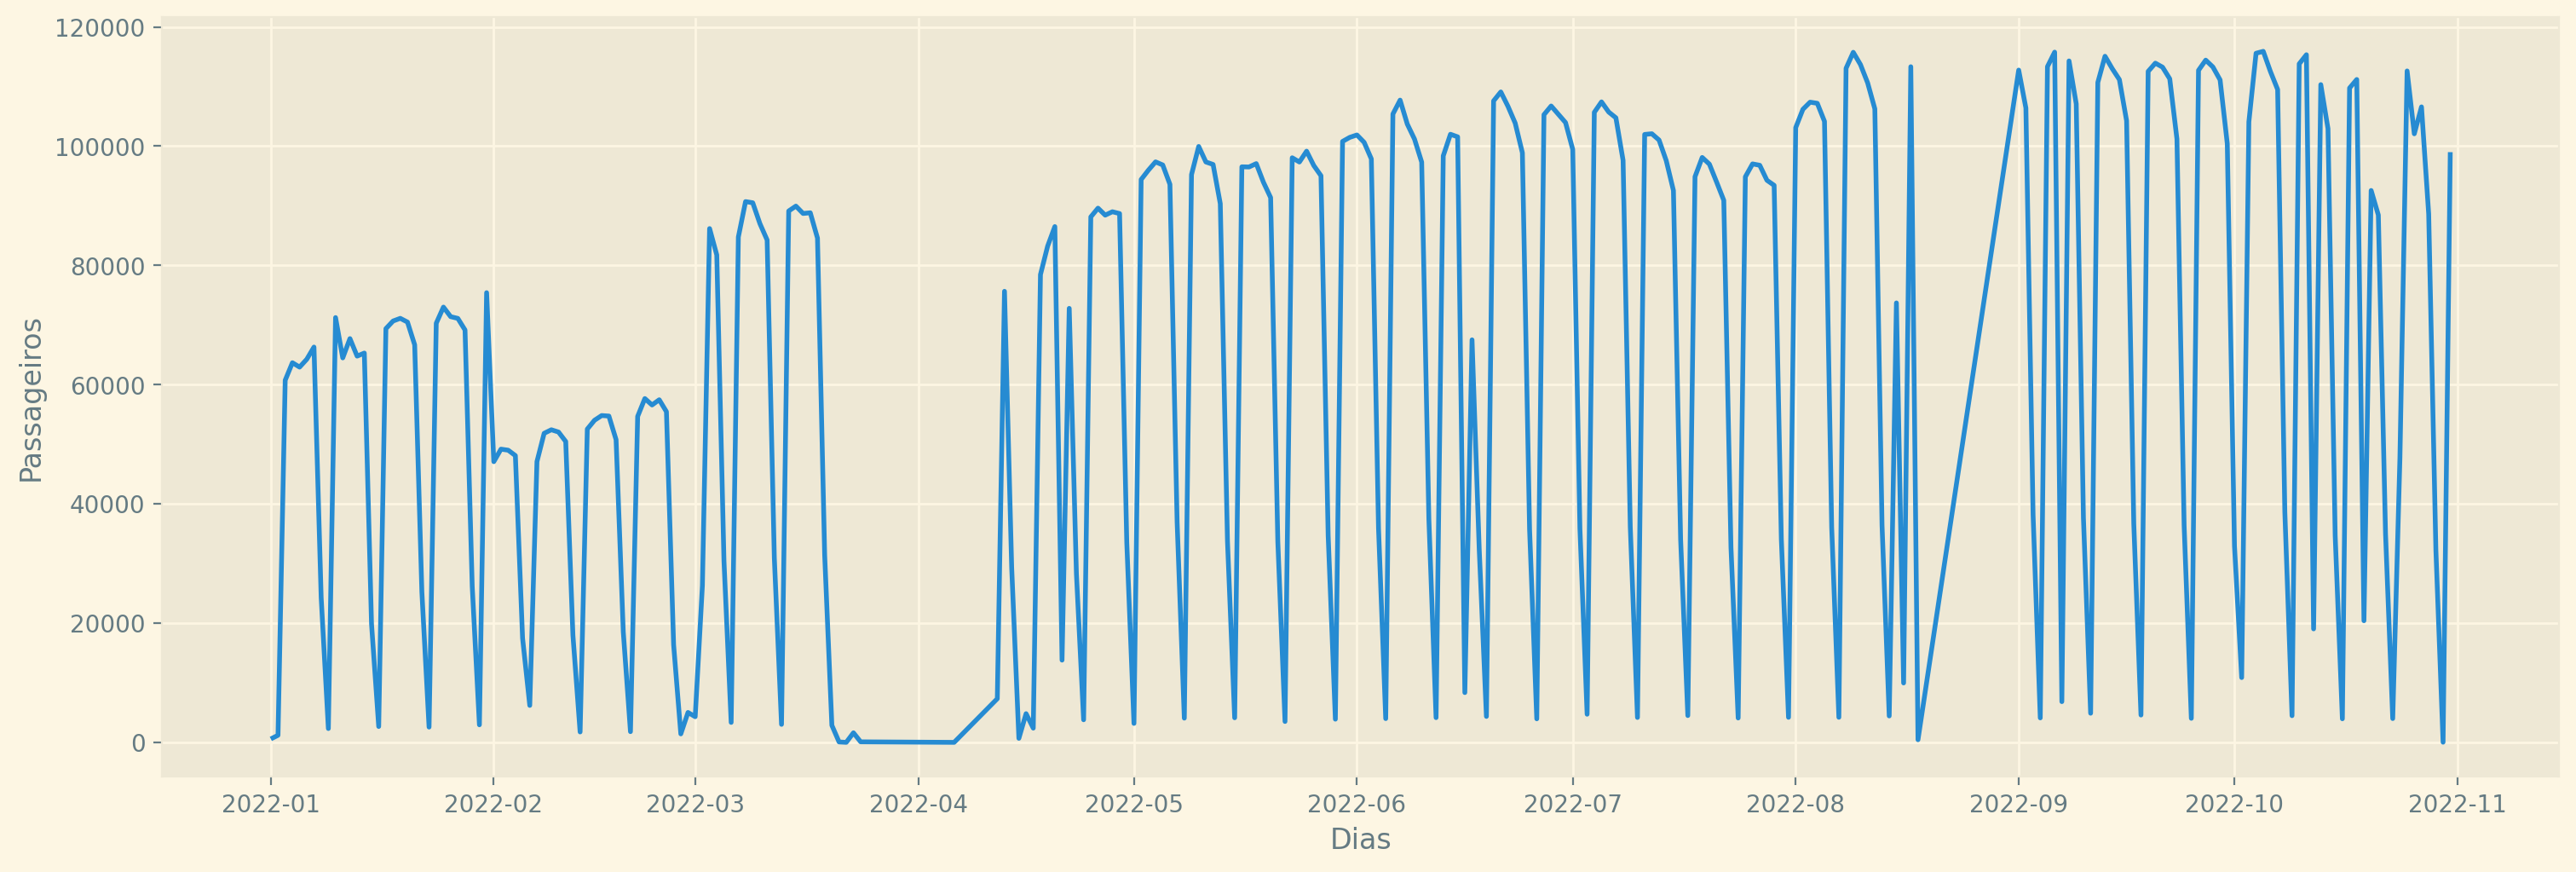

In [3]:
# gráfico com a vizualização da linha do tempo de 2022
def plot_ts():
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.lineplot(x = freq_pas['Data Coleta'], y = freq_pas['Passageiros'])
    ax.set_xlabel('Dias')
    plt.show()

plot_ts()

O gráfico da série temporal indica que existe uma sanzonalidade semanal, mas evindencia problemas que teremos que tratar para fazer a predição com série temporal. O mais evidente é o período zerado, que corresponde ao período de greve de 23 dias dos motoristas e cobradores de ônibus. Outro fator que pode prejudicar a criação de uma predição são feriados pois ocorrem uma diminuição significativa do número de passageiros. 

Link notícia greve: https://g1.globo.com/pi/piaui/noticia/2022/04/12/chega-ao-fim-greve-de-motoristas-e-cobradores-de-onibus-em-teresina-apos-23-dias.ghtml

A tabela a seguir apresenta as medidas descritivas mais importantes e o problema dos valores mínimos. 

O único dia que tem um valor mais próximo da realidade é o domingo.

Importante destacar que o valor mínimo irá influenciar o valor da média e do desvio-padrão devido ao seu inclusão para os cálculos dessas medidas.

In [4]:
# tabela com medidas descritivas

def medidas(freq_pas):
    data_day = freq_pas.groupby('dia_semana')['Passageiros'].describe().round(2).reset_index()
    data_day = data_day.set_index('dia_semana')
    return(data_day)

data_day = medidas(freq_pas)
data_day

count      mean       std    min       25%      50%        75%  \
dia_semana                                                                   
0            40.0  83984.00  30549.58   26.0  71009.00  95048.5  105303.75   
1            39.0  84991.46  33666.52    1.0  67575.50  97335.0  108405.00   
2            40.0  79814.40  34240.50    0.0  61350.00  96884.0  104107.25   
3            40.0  81796.85  33022.00   89.0  64648.50  94128.0  105211.00   
4            38.0  84476.00  22282.10  672.0  70071.75  91140.5   99307.00   
5            39.0  30102.05   8988.70  575.0  27221.50  33653.0   35988.00   
6            39.0   3706.67   1667.67   23.0   2900.00   3984.0    4200.00   

                 max  
dia_semana            
0           113803.0  
1           115768.0  
2           115903.0  
3           114292.0  
4           109493.0  
5            38663.0  
6            10867.0

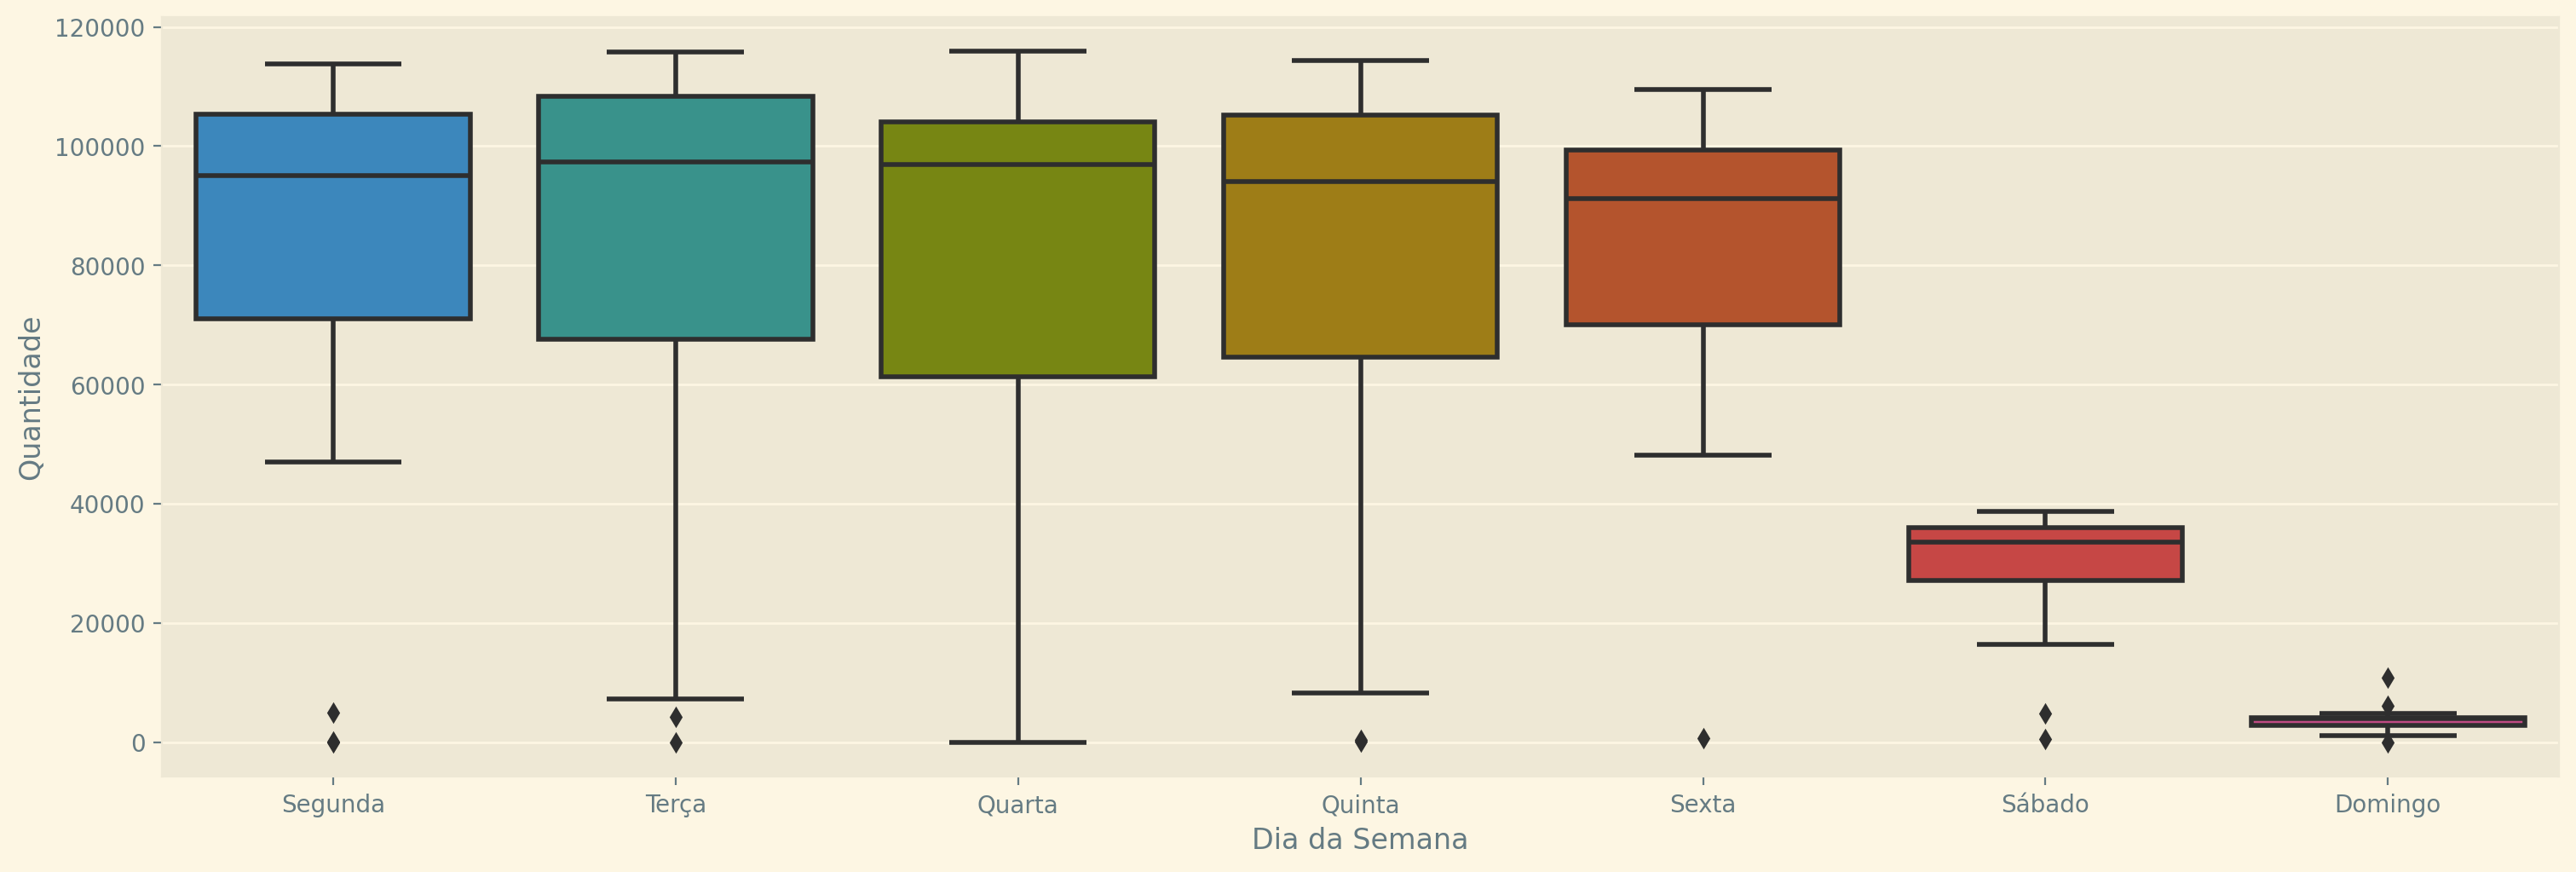

In [5]:
# box-plot com a divisão dos passageiros durante os dias da semana

def box_day(freq_pas):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.boxplot(x = freq_pas['dia_semana'], y = freq_pas['Passageiros'])
    ax.set_ylabel('Quantidade')
    ax.set_xlabel('Dia da Semana')
    ax.set_xticklabels(["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]) 
    plt.show()

box_original = box_day(freq_pas)
box_original

# Correção dos dados

Diante desses dados inexistes e irreais, teremos que definir estimadores para substituir os valores. Para isso, o primeiro procedimento foi retirar os valores muitos baixos e muito altos, os outlines existentes no gráfico. 

Para os dias úteis, limitamos esses valores a 50 mil como limite inferior e 125 mil como limite superior, para sábado, o limite inferior foi estabelecido em 18 mil e com um máximo de 40 mil. Para o domingo, foi imposto um limite mínimo de 1000 e máximo de 15 mil.

Na tabela abaixo, podemos ler medidas descritivas mais próximas realistas e o box-plot confirmando as informações de forma gráfica. 

Com essas medidas, podemos estabelecer valores para substituir os valores ausentes ou errados. 

In [6]:
# Filter out low passenger counts on weekdays
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 50000) & (freq_pas.dia_semana < 5)].index) # Low values
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 125000) & (freq_pas.dia_semana < 5)].index) # High values

# Filter out low and high passenger counts on Saturdays
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 18000) & (freq_pas.dia_semana == 5)].index) # Low values
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 40000) & (freq_pas.dia_semana == 5)].index) # High values

# Filter out very low and high passenger counts on Sundays
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 15000) & (freq_pas.dia_semana == 6)].index) # High values
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 1000) & (freq_pas.dia_semana == 6)].index) # Low values

# Assuming `medidas` is a function that processes `freq_pas`
data_day_c = medidas(freq_pas)


In [7]:

data_day_c

count      mean       std      min       25%       50%        75%  \
dia_semana                                                                      
0            35.0  93128.57  17542.89  52544.0  81602.50   98049.0  105528.00   
1            34.0  95470.79  19464.42  51836.0  89685.50  100708.5  110655.75   
2            33.0  93007.79  18655.03  52430.0  86512.00   97360.0  105721.00   
3            34.0  93262.38  18182.69  52045.0  87449.25   96885.5  107036.50   
4            36.0  87814.36  16581.05  50460.0  79509.00   91960.5   99689.00   
5            34.0  32846.41   4946.92  18552.0  31635.25   34062.5   36134.75   
6            38.0   3803.61   1574.77   1188.0   2960.00    3987.0    4201.00   

                 max  
dia_semana            
0           113803.0  
1           115768.0  
2           115903.0  
3           114292.0  
4           109493.0  
5            38663.0  
6            10867.0

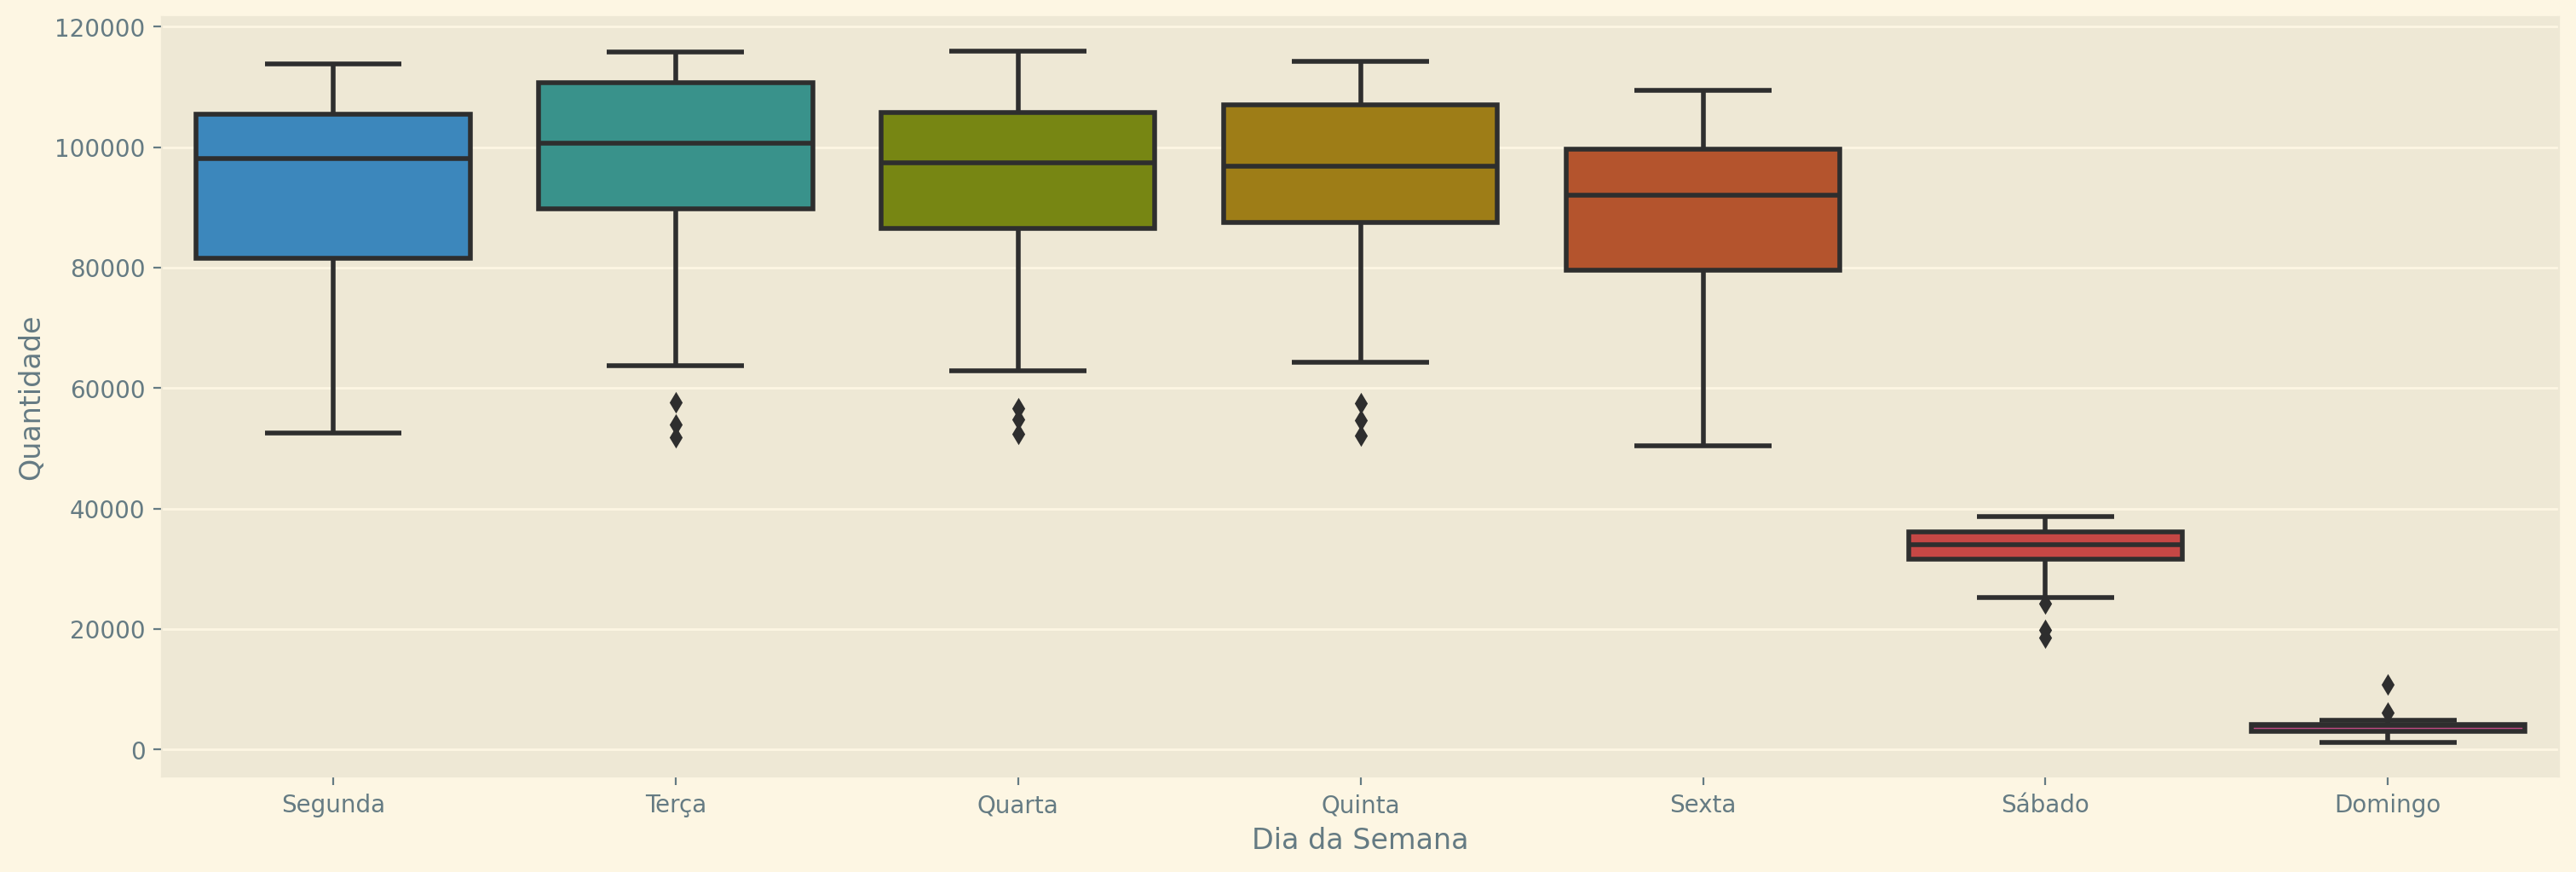

In [8]:
box_day(freq_pas)


Diante dos dados outliers presentes provinientes dos feriados e aos dias sem contagem devido a greve, precisamos encontrar um forma de substituir esses valores. 

O procedimento adotado consiste em analisar a distribuição por dia da semana e realizar o teste de normalidade de Shapiro-will $(\chi^{2})$. Caso seja constatado a normalidade, o valor será substituído pela média, caso não haja normalidade, pela mediana.

O teste de $\chi^{2}$ tem como $H_{0}$ a normalidade dos dados e como $H_{1}$ a não normalidade. Para  valor de significância foi adotado o padrão de 0,05, o que significa um intervalo de confiança  de 95%.

Este método foi definido pois podemos identificar que existe um comportamento diferente para cada dia da semana, buscando não alterar a distribuição dos dados, realizamos uma análise que considera os dados em ralação a cada dia da semana. 

In [9]:
def shapiro_test_days(freq_pas):
    # Perform Shapiro-Wilk test for each day of the week
    shapiro_results = []

    for day in range(7):
        day_data = freq_pas[freq_pas['dia_semana'] == day]
        shapiro_stat, shapiro_pvalue = stats.shapiro(day_data['Passageiros'])
        shapiro_results.append(shapiro_pvalue)

    # Compile the p-values into a DataFrame
    df = pd.DataFrame({'pvalor': shapiro_results})
    return df.round(5)

# Call the function with freq_pas as input
shapiro_day = shapiro_test_days(freq_pas)
shapiro_day

pvalor
0  0.00450
1  0.00062
2  0.00244
3  0.00114
4  0.00333
5  0.00022
6  0.00000

Outro obstáculo a ser superado consiste que há dias que não existem na tabela. Devido a greve, houve dias que não ocorreram registro de passageiro e não estão nem zerados. A solução encontrada foi construir um data.frame com todos os dias do ano até a última data de registro utlizada na análise, a data limite utilizada para construção da previsão. A segunda etapa consistiui em unir as tabelas e substituir valores `NA` por 0. Contruímos a função *full_days_2022()* para estre procedimento.

In [10]:
def generate_full_days_2022(freq_pas):
    # Get the last day from the provided data
    last_day = np.array(freq_pas['Data Coleta'])[-1]

    # Selecting only the date and passenger count columns from the main table
    data_corrected = freq_pas[['Data Coleta', 'Passageiros']]

    # Create a date range for all days in 2022 up to the last day of analysis
    days_2022 = pd.date_range(start='2022-01-02', end=last_day)

    # Create a DataFrame with the generated dates
    days_full = pd.DataFrame({'Data Coleta': days_2022})

    # Convert 'Data Coleta' column to datetime format
    days_full['Data Coleta'] = pd.to_datetime(days_full['Data Coleta'], format='%Y-%m-%d')

    # Merge the generated dates with the original data, filling missing entries with zeros
    days_merge = pd.merge(days_full, data_corrected, how='outer', on='Data Coleta')
    days_merge['Passageiros'] = days_merge['Passageiros'].fillna(0)

    # Add a column for the day of the week
    days_merge['dia_semana'] = days_merge['Data Coleta'].dt.dayofweek

    return days_merge

# Update freq_pas with the new dataset
freq_pas = generate_full_days_2022(freq_pas)


Com a tabela construída, com os valores 0, realizamos a alteração destes valores de acordo com os valores estabelicidos na tabela sem os valores irreais. O valor será substituído de acordo com teste de normalidade.

In [11]:
for i in range(7):
    if shapiro_day['pvalor'][i] > 0.05:
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['mean'][i], freq_pas['Passageiros'])
    
    else:                                     
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0 ) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31') & (freq_pas['Data Coleta'] < '2022-09-30'), data_day_c['50%'][i] , freq_pas['Passageiros'])

Para confirmar alteraçãos dos valores, vizuallizamos o box-plot novamente. Percebemos a correção implantanda. 

O segundo gráfico  mostra  a linha temporal corrigida. 

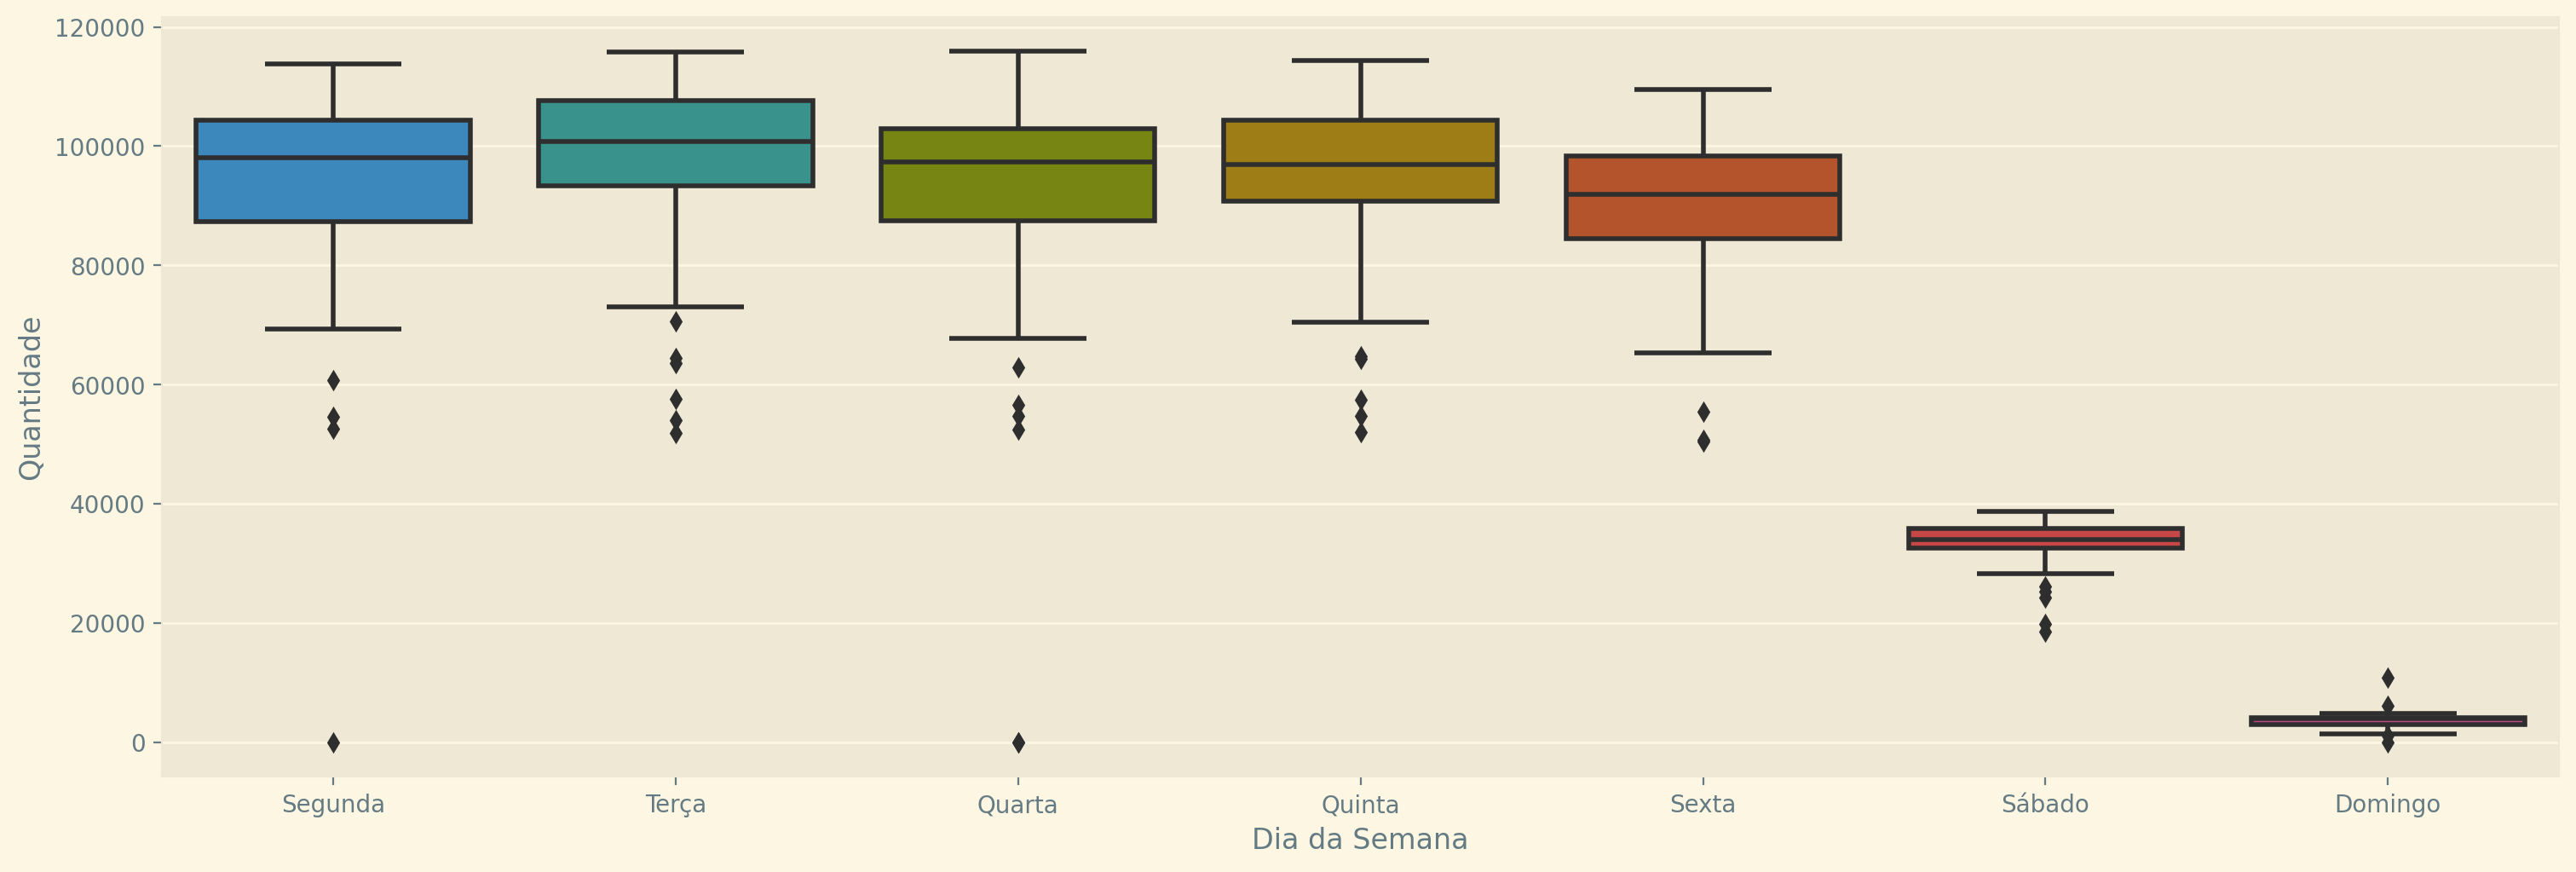

In [12]:
# making the boxplot to analyze whether the outlines were removed
box_correct = box_day(freq_pas)
box_correct

Percebe-se que existem valores zerados para segunda e quarta. Isto ocorre pelo fato de limitarmos a correção até o mês setembro. Iremos construir os modelo de previsão para o último mês da série histórica, outubro, dessa forma, deixou-se inalterado o mês final.

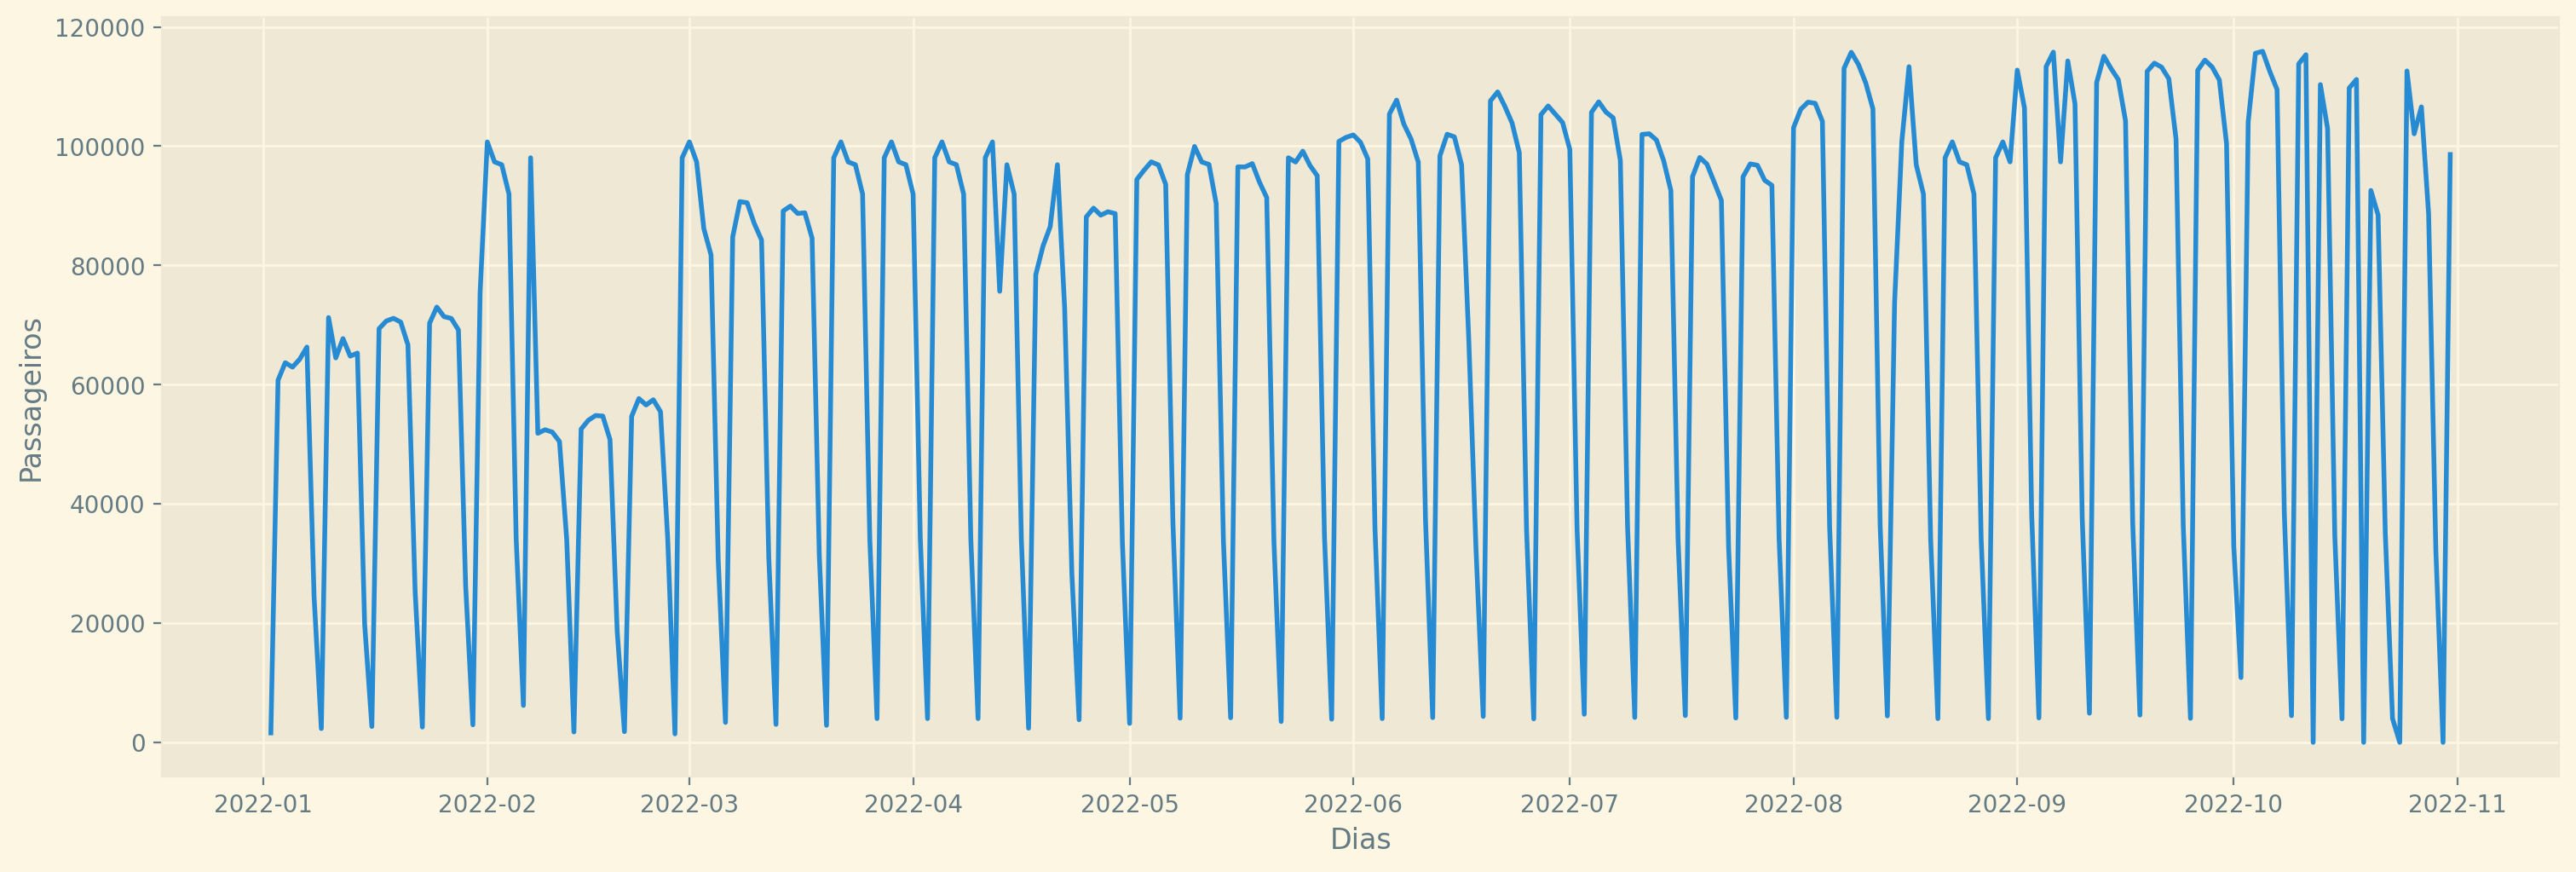

In [13]:
# gráfico com a vizualização da linha do tempo de 2022 com as data corrigidas 
plot_ts()

Podemos perceber que na série original que na parte final do período analisado, referente ao mês de outubro, há um comportamento  atípico e sem o padrão configurado as datas anteriores. Devido as eleições e número de feriados, o compotarmento da série é alterado o que resulta em valores de erros maiores. 

Para os modelos de previsão, iremos utilizar a série corrigida que ainda apresenta um comportamento influenciado pelas oscilações não previstas, só que em um grau menor, todavia, após um período mensal, é importante realizar a construção de outro modelo de previsão da série e avaliar as mundanças no modelo criado.

Outro processo futuro é a acompanhar a estabilização da frequência de passageiros. Podemos ver no gráfico que há uma diferença nos valores de passageiros comparando primeiro e segundo semestre, resultado de um aumento de pessoas transportadas. No segundo semestre, os passageiros, em dias úteis superam os 100 mil, todavia, esse comportamento só se estabilizou em maio e ocorreu outro incremento a partir de agosto, onde os valores se aproximam dos 120 mil passageiros. 

# Previsão de passageiros

## Séries Temporais

Com a correção da série de passageiros, podemos realizar um modelo de previsão para o transporte público de Teresina. Para isto, iremos utilizar, numa primeira análise, com séries temporais, o modelo Arima com Sazonalidade, SARIMA.

Para séries temporais, o processo é um pouco exigente devido a existência de pressupostos para a criação de modelos de previsão utlizando ARIMA. Temos que testar a série em relação a sua estacionariedade (média constante e dependência da função de autocovariância dependente somente do tempo). Pelo comportamento do gráfico, fica claro que existe a sazonalidade, direcionando para o uso de um modelo SARIMA. 

Iremos realizar os testes para verificar a cumprimento dos pressupostos e, caso não seja cumprido, iremos realizar a diferença ($X_{t} - X_{t-1}$), para conseguir deixar a série estacionária

Uma das abordagens de séries temporais é que podemos realizar a divisão da série temporal em três elementos:

- Tendência
- Sazonalidade
- Erro

Tendência consiste no comportamento puro da série e conseguimos enxergar a direção que a série segue, podendo ser de alta, baixa ou de estabilidade

Sazonalidade indica a repetição do processo em relação ao seu funcionamento, após uma quantidade t de períodos, a série repete seu comportamento. 

Os erros são os movimentos que não são captados nos pela tendência e pela sazonalidade. Consiste no aspecto aletório da séries.

No gráfico abaixo, o comportamento da série e as três partes isoladas.

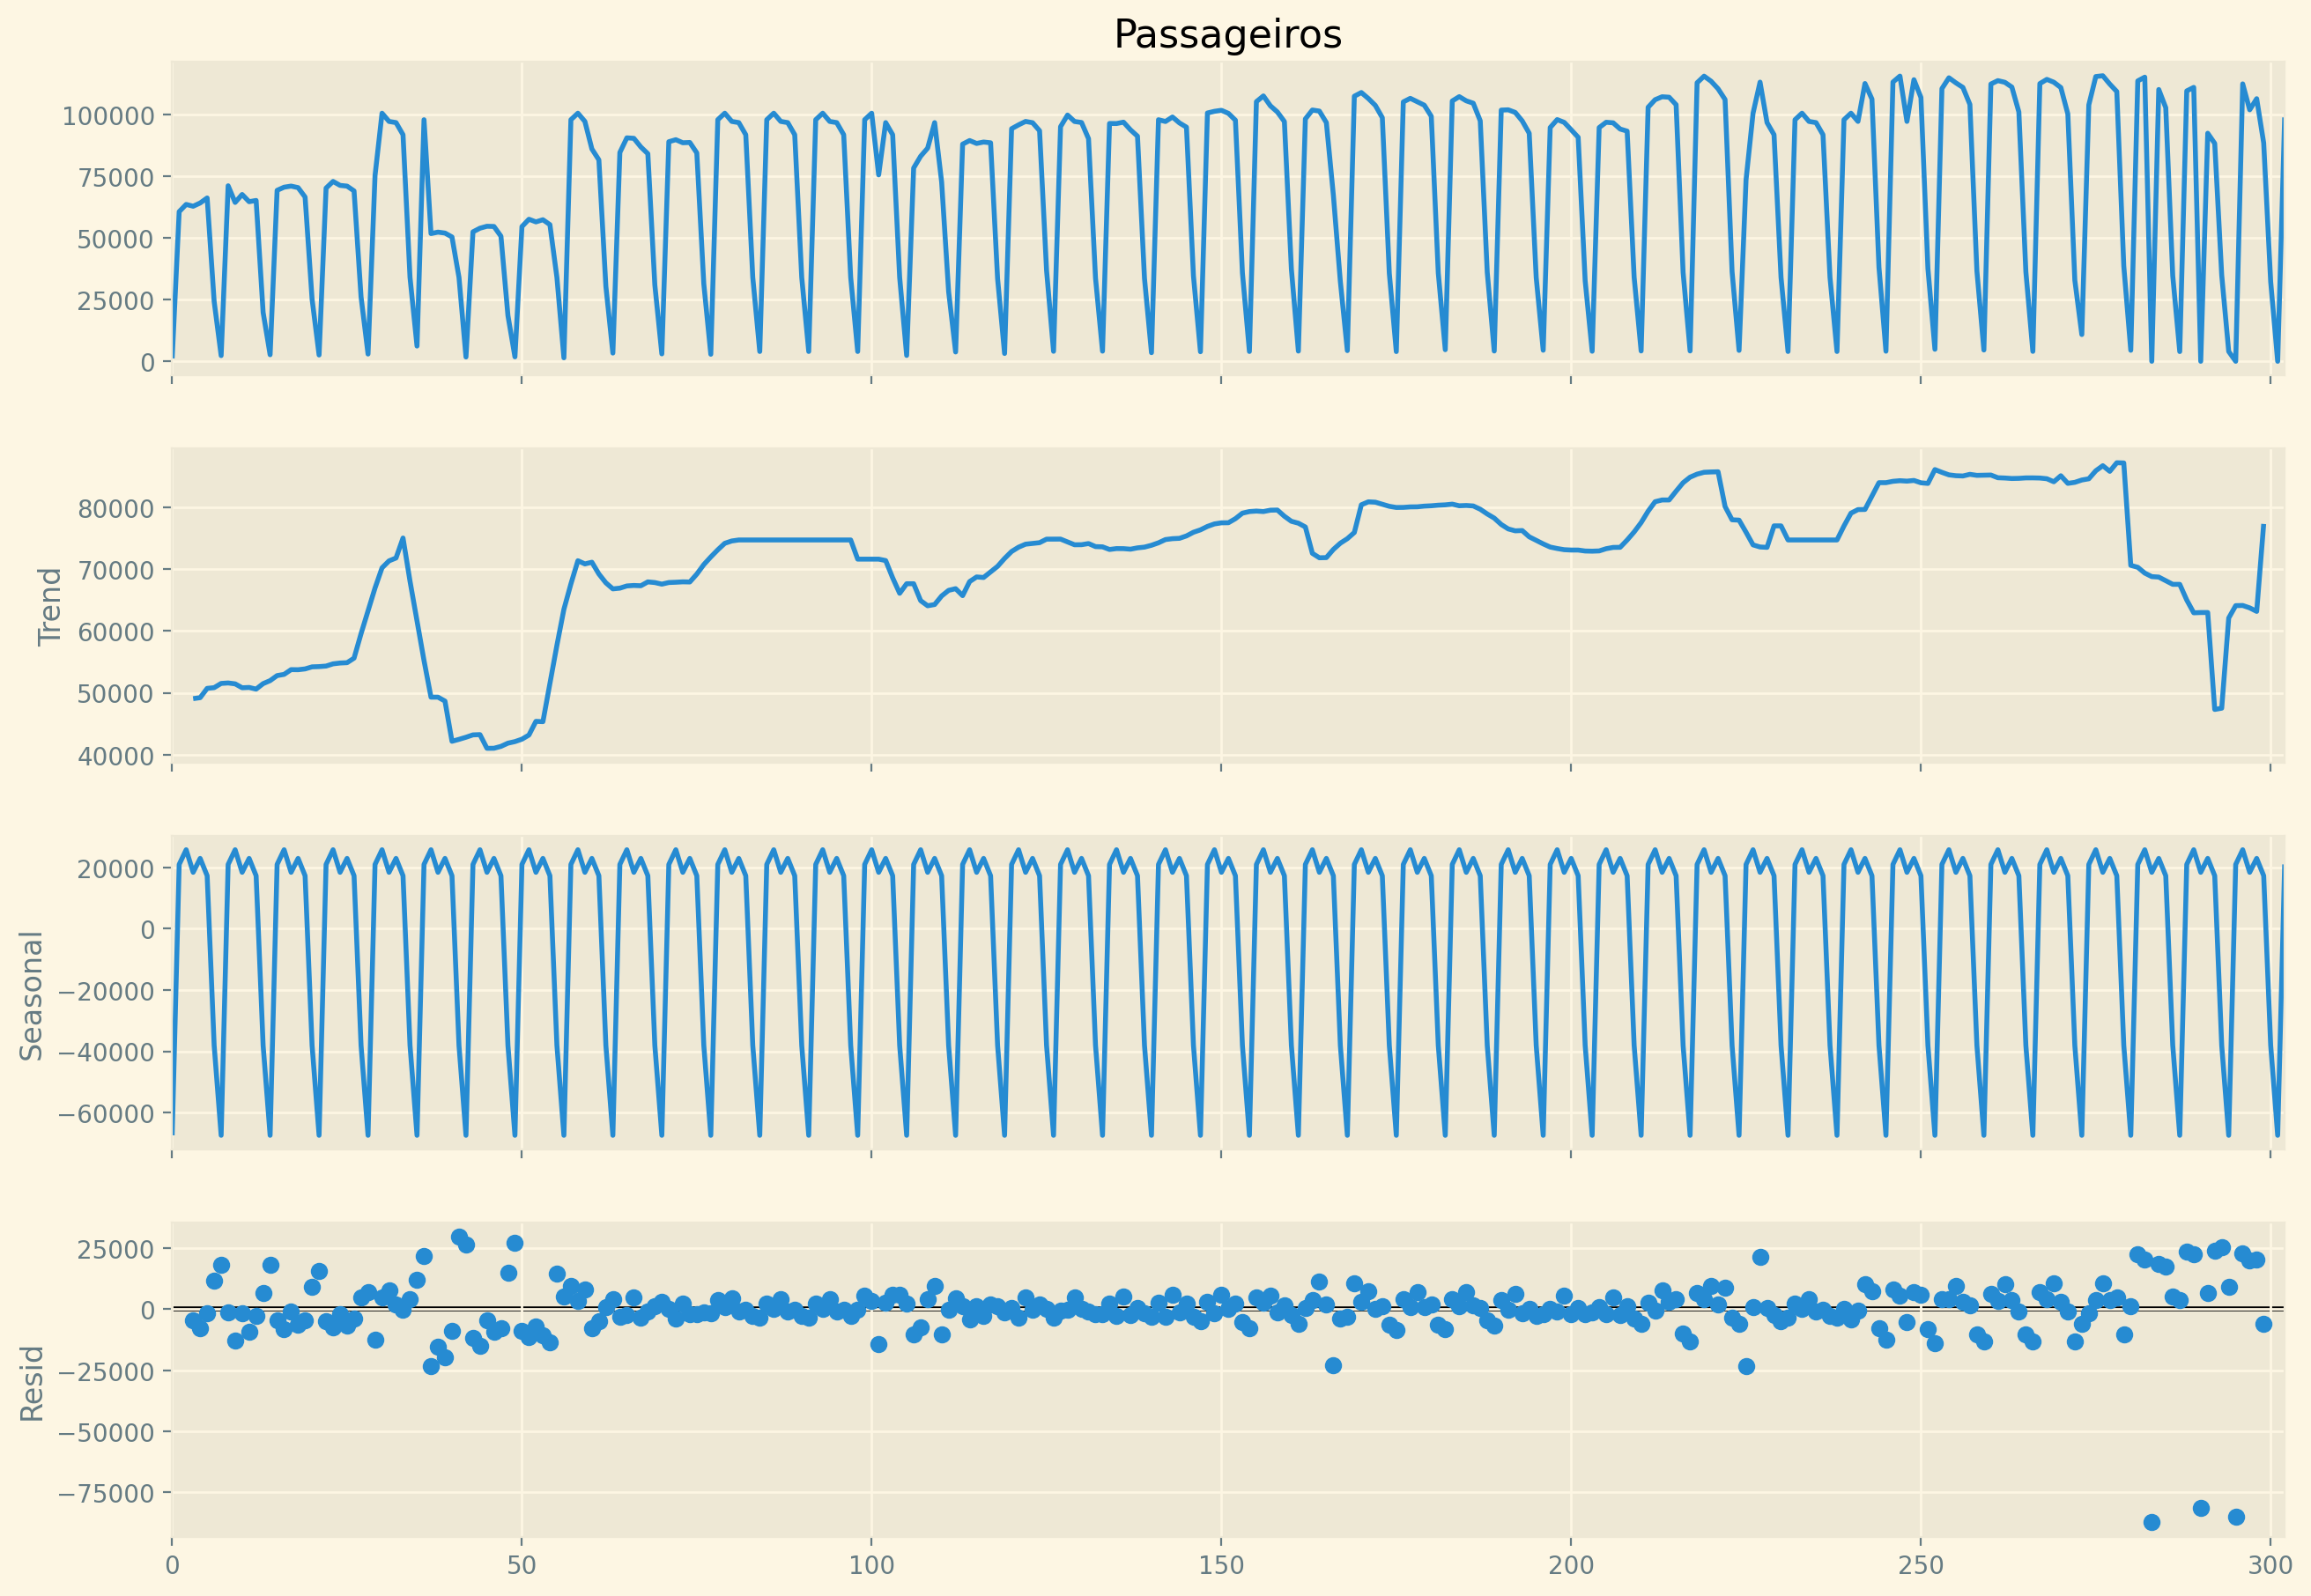

In [14]:
result = seasonal_decompose(freq_pas['Passageiros'], period = 7,  model='additive')
fig = result.plot()
fig.set_size_inches(15,10)
fig.show()

Após identificar os componentes da série, podemos realizar o teste de estacionariedade para descobrimos se iremos precisar de alguma transformação para possibilitar a criação do modelo.

A função abaixo foi adaptada para nosso trabalho e auxilia na análise. No teste de Fuller, com intervalo de confiança de 95%, o p-valor menor que 0,05 indica a série estacionária. 

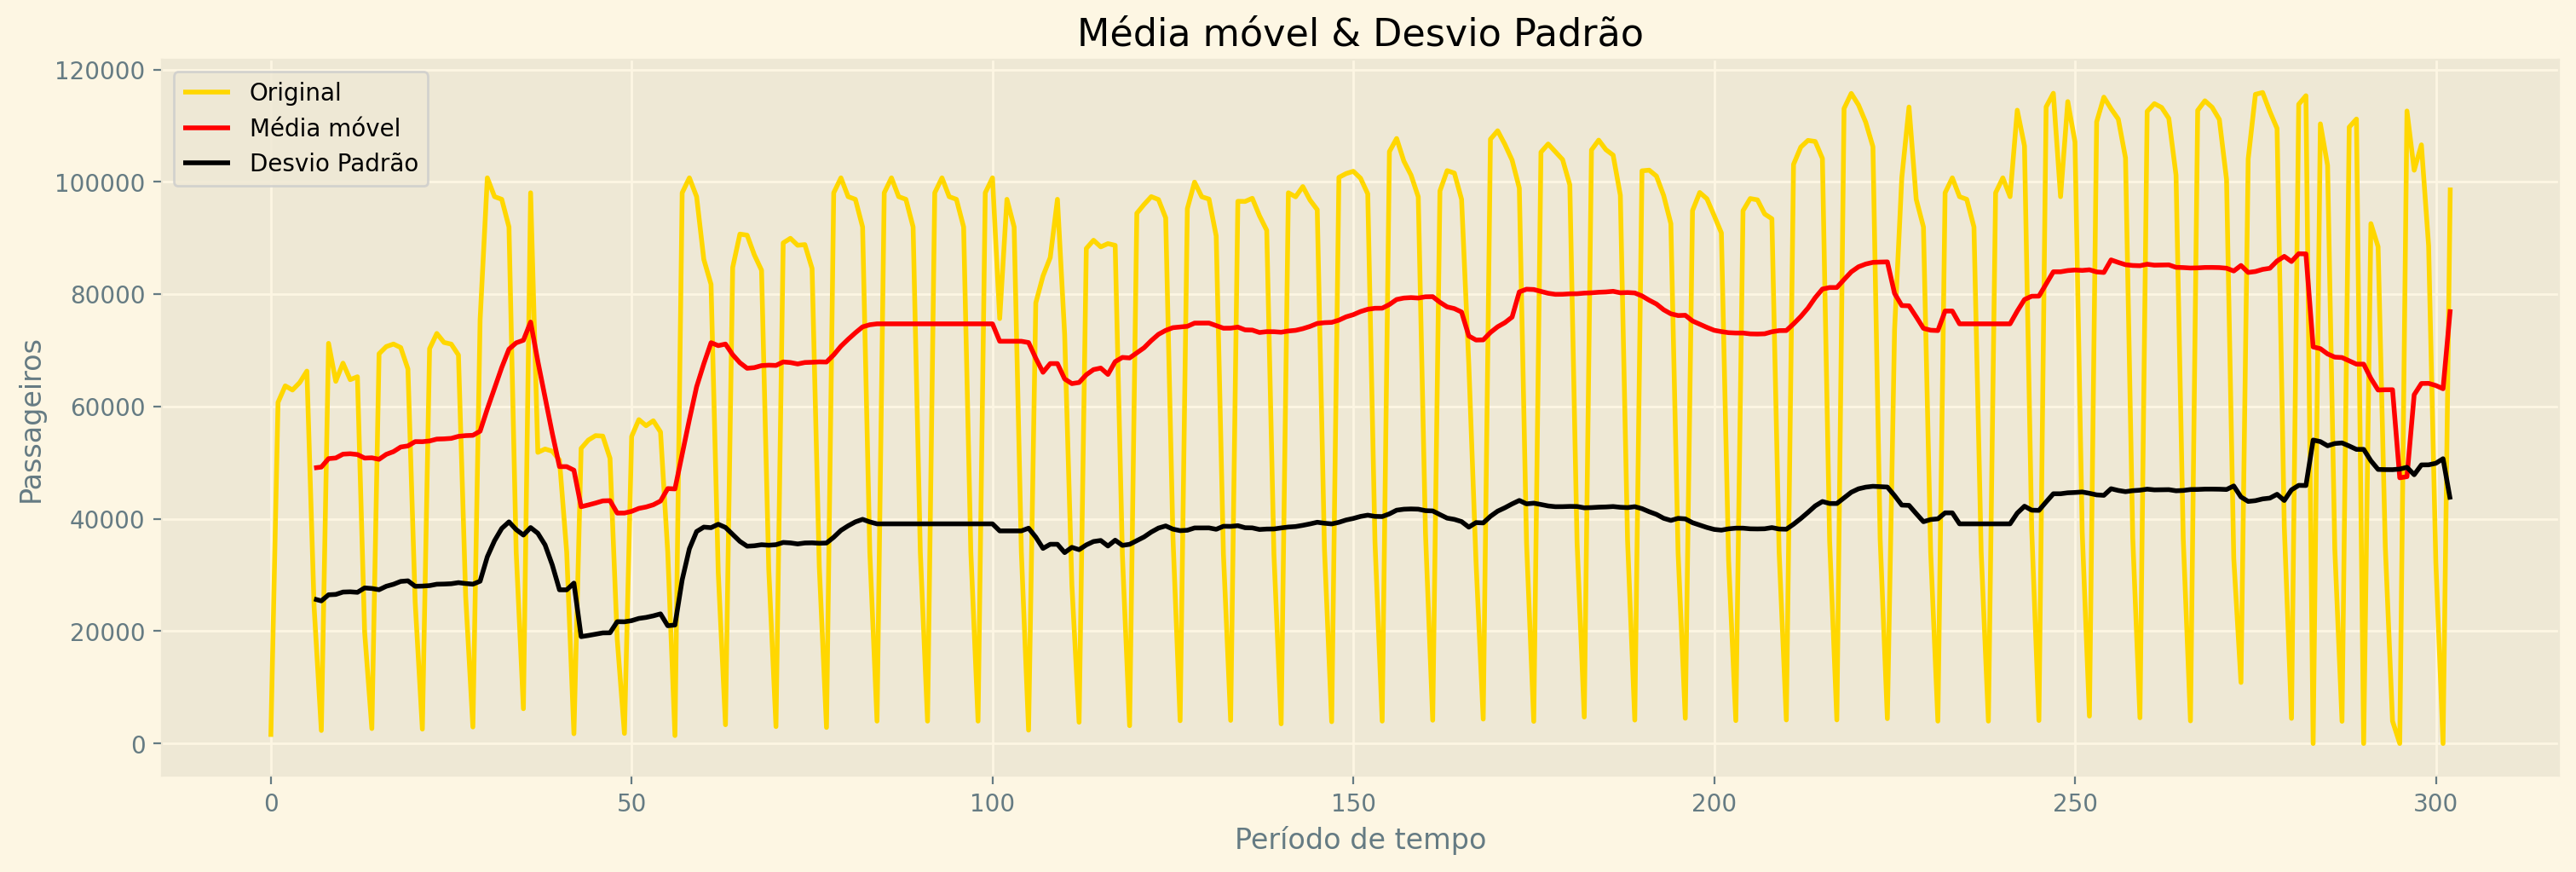

Test Statistic                  -2.689000
p-value                          0.075961
#Lags Used                      14.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [15]:

# Função baseada no código em: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

def test_stationarity(timeseries, t):

    rolmean = timeseries.rolling(t).mean()
    rolstd = timeseries.rolling(t).std()

#Plot rolling statistics:
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15,5)
    plt.plot(timeseries, color='gold',label='Original')
    plt.plot(rolmean, color='red', label='Média móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Média móvel & Desvio Padrão')
    plt.xlabel("Período de tempo")
    plt.ylabel('Passageiros')
    plt.show()
    #Perform Dickey-Fuller test:
    #print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(freq_pas['Passageiros'],7)

Concluímos ao nível de 95% que a série não é estacionária e precisaremos realizar nenhuma transformação para deixar para deixar a série adequada ao presuposto da estaciónariedade.

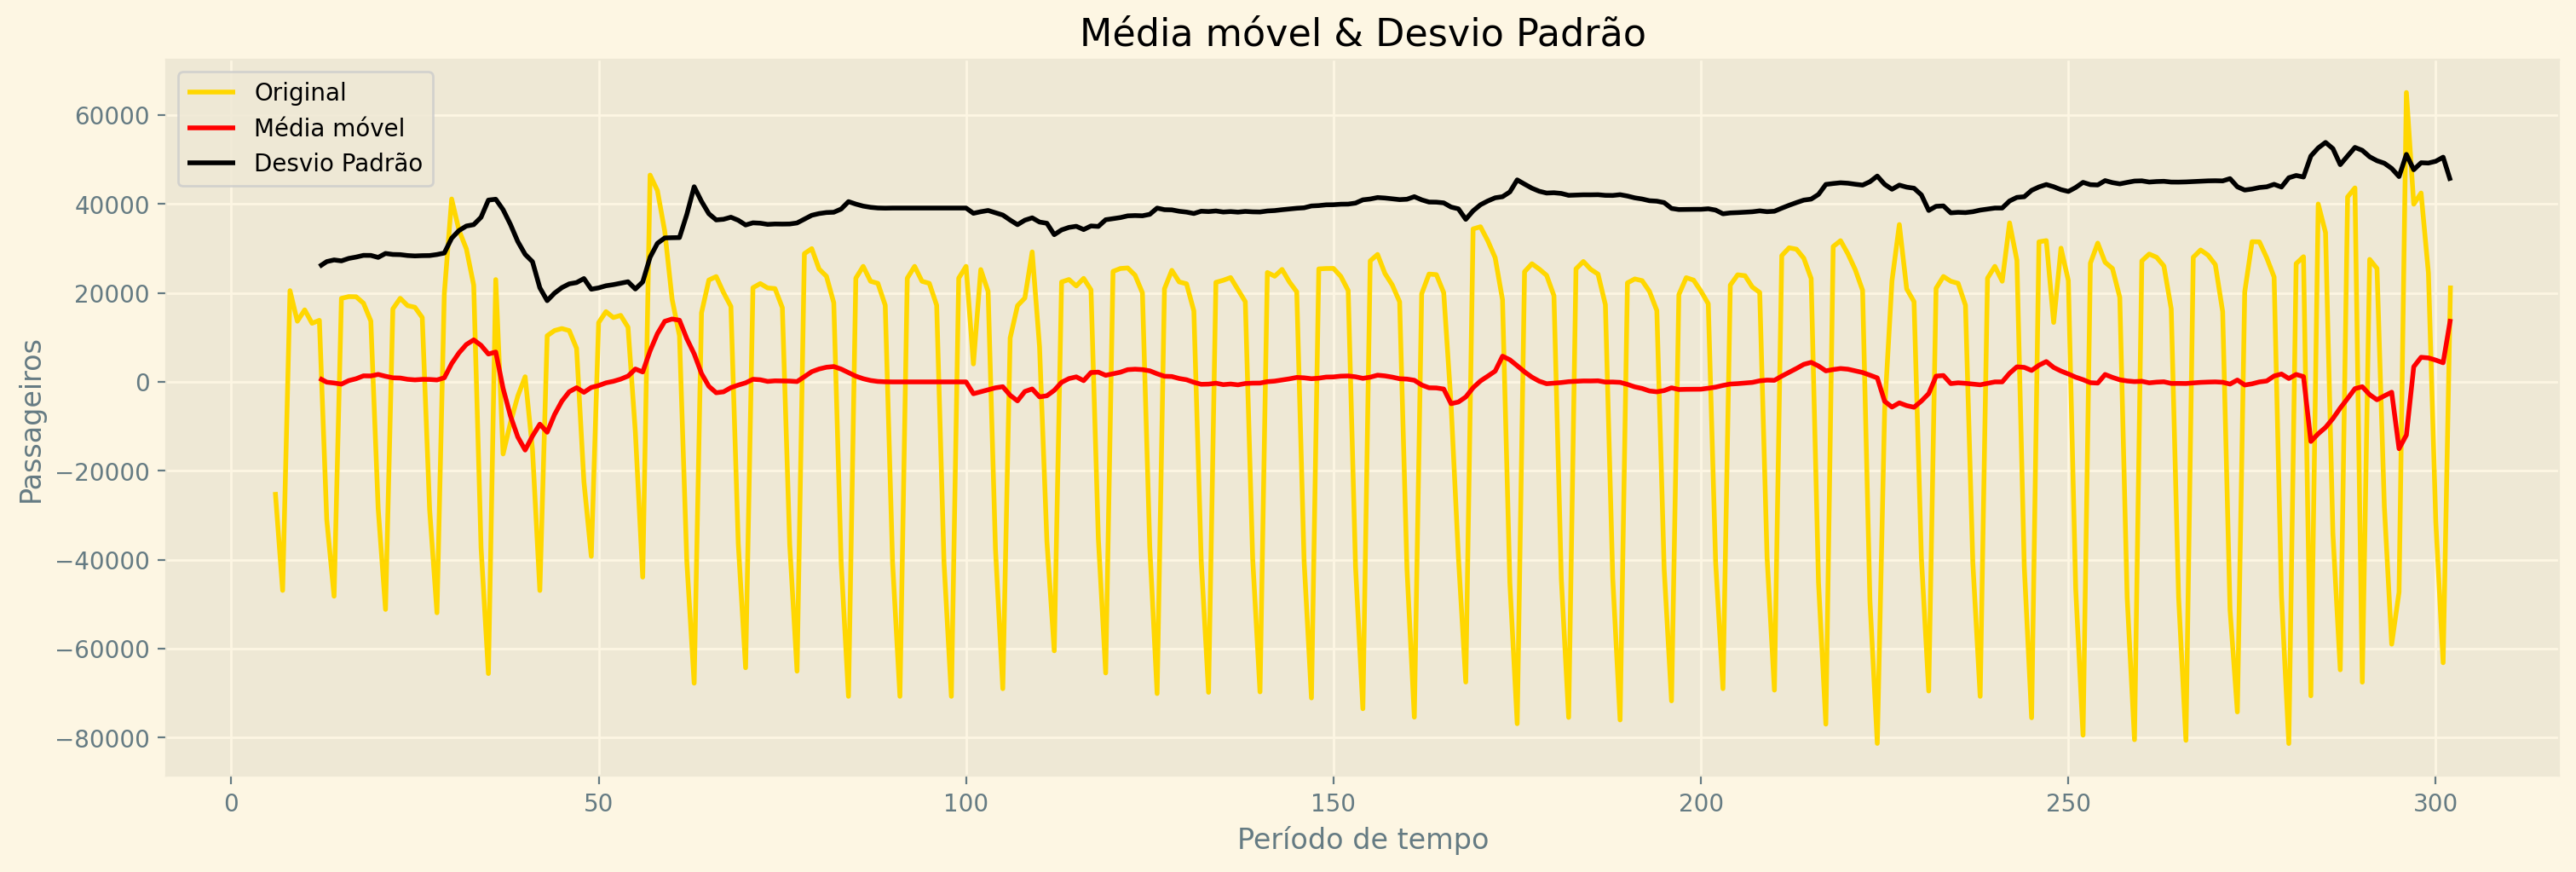

Test Statistic                  -4.976378
p-value                          0.000025
#Lags Used                      15.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


In [24]:
freq_pas['Rooling Mean'] = freq_pas['Passageiros'].rolling(window= 7).mean()
freq_pas['Diff'] = freq_pas['Passageiros'] - freq_pas['Rooling Mean']
list_diff = freq_pas['Diff'].dropna()


def test_stationarity(timeseries, t):

    rolmean = timeseries.rolling(t).mean()
    rolstd = timeseries.rolling(t).std()

#Plot rolling statistics:
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15,5)
    plt.plot(timeseries, color='gold',label='Original')
    plt.plot(rolmean, color='red', label='Média móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Média móvel & Desvio Padrão')
    plt.xlabel("Período de tempo")
    plt.ylabel('Passageiros')
    plt.show()
    #Perform Dickey-Fuller test:
    #print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(list_diff ,7)

Conseguimos transformar a série em uma série estacionária realizando o processo da diferença 

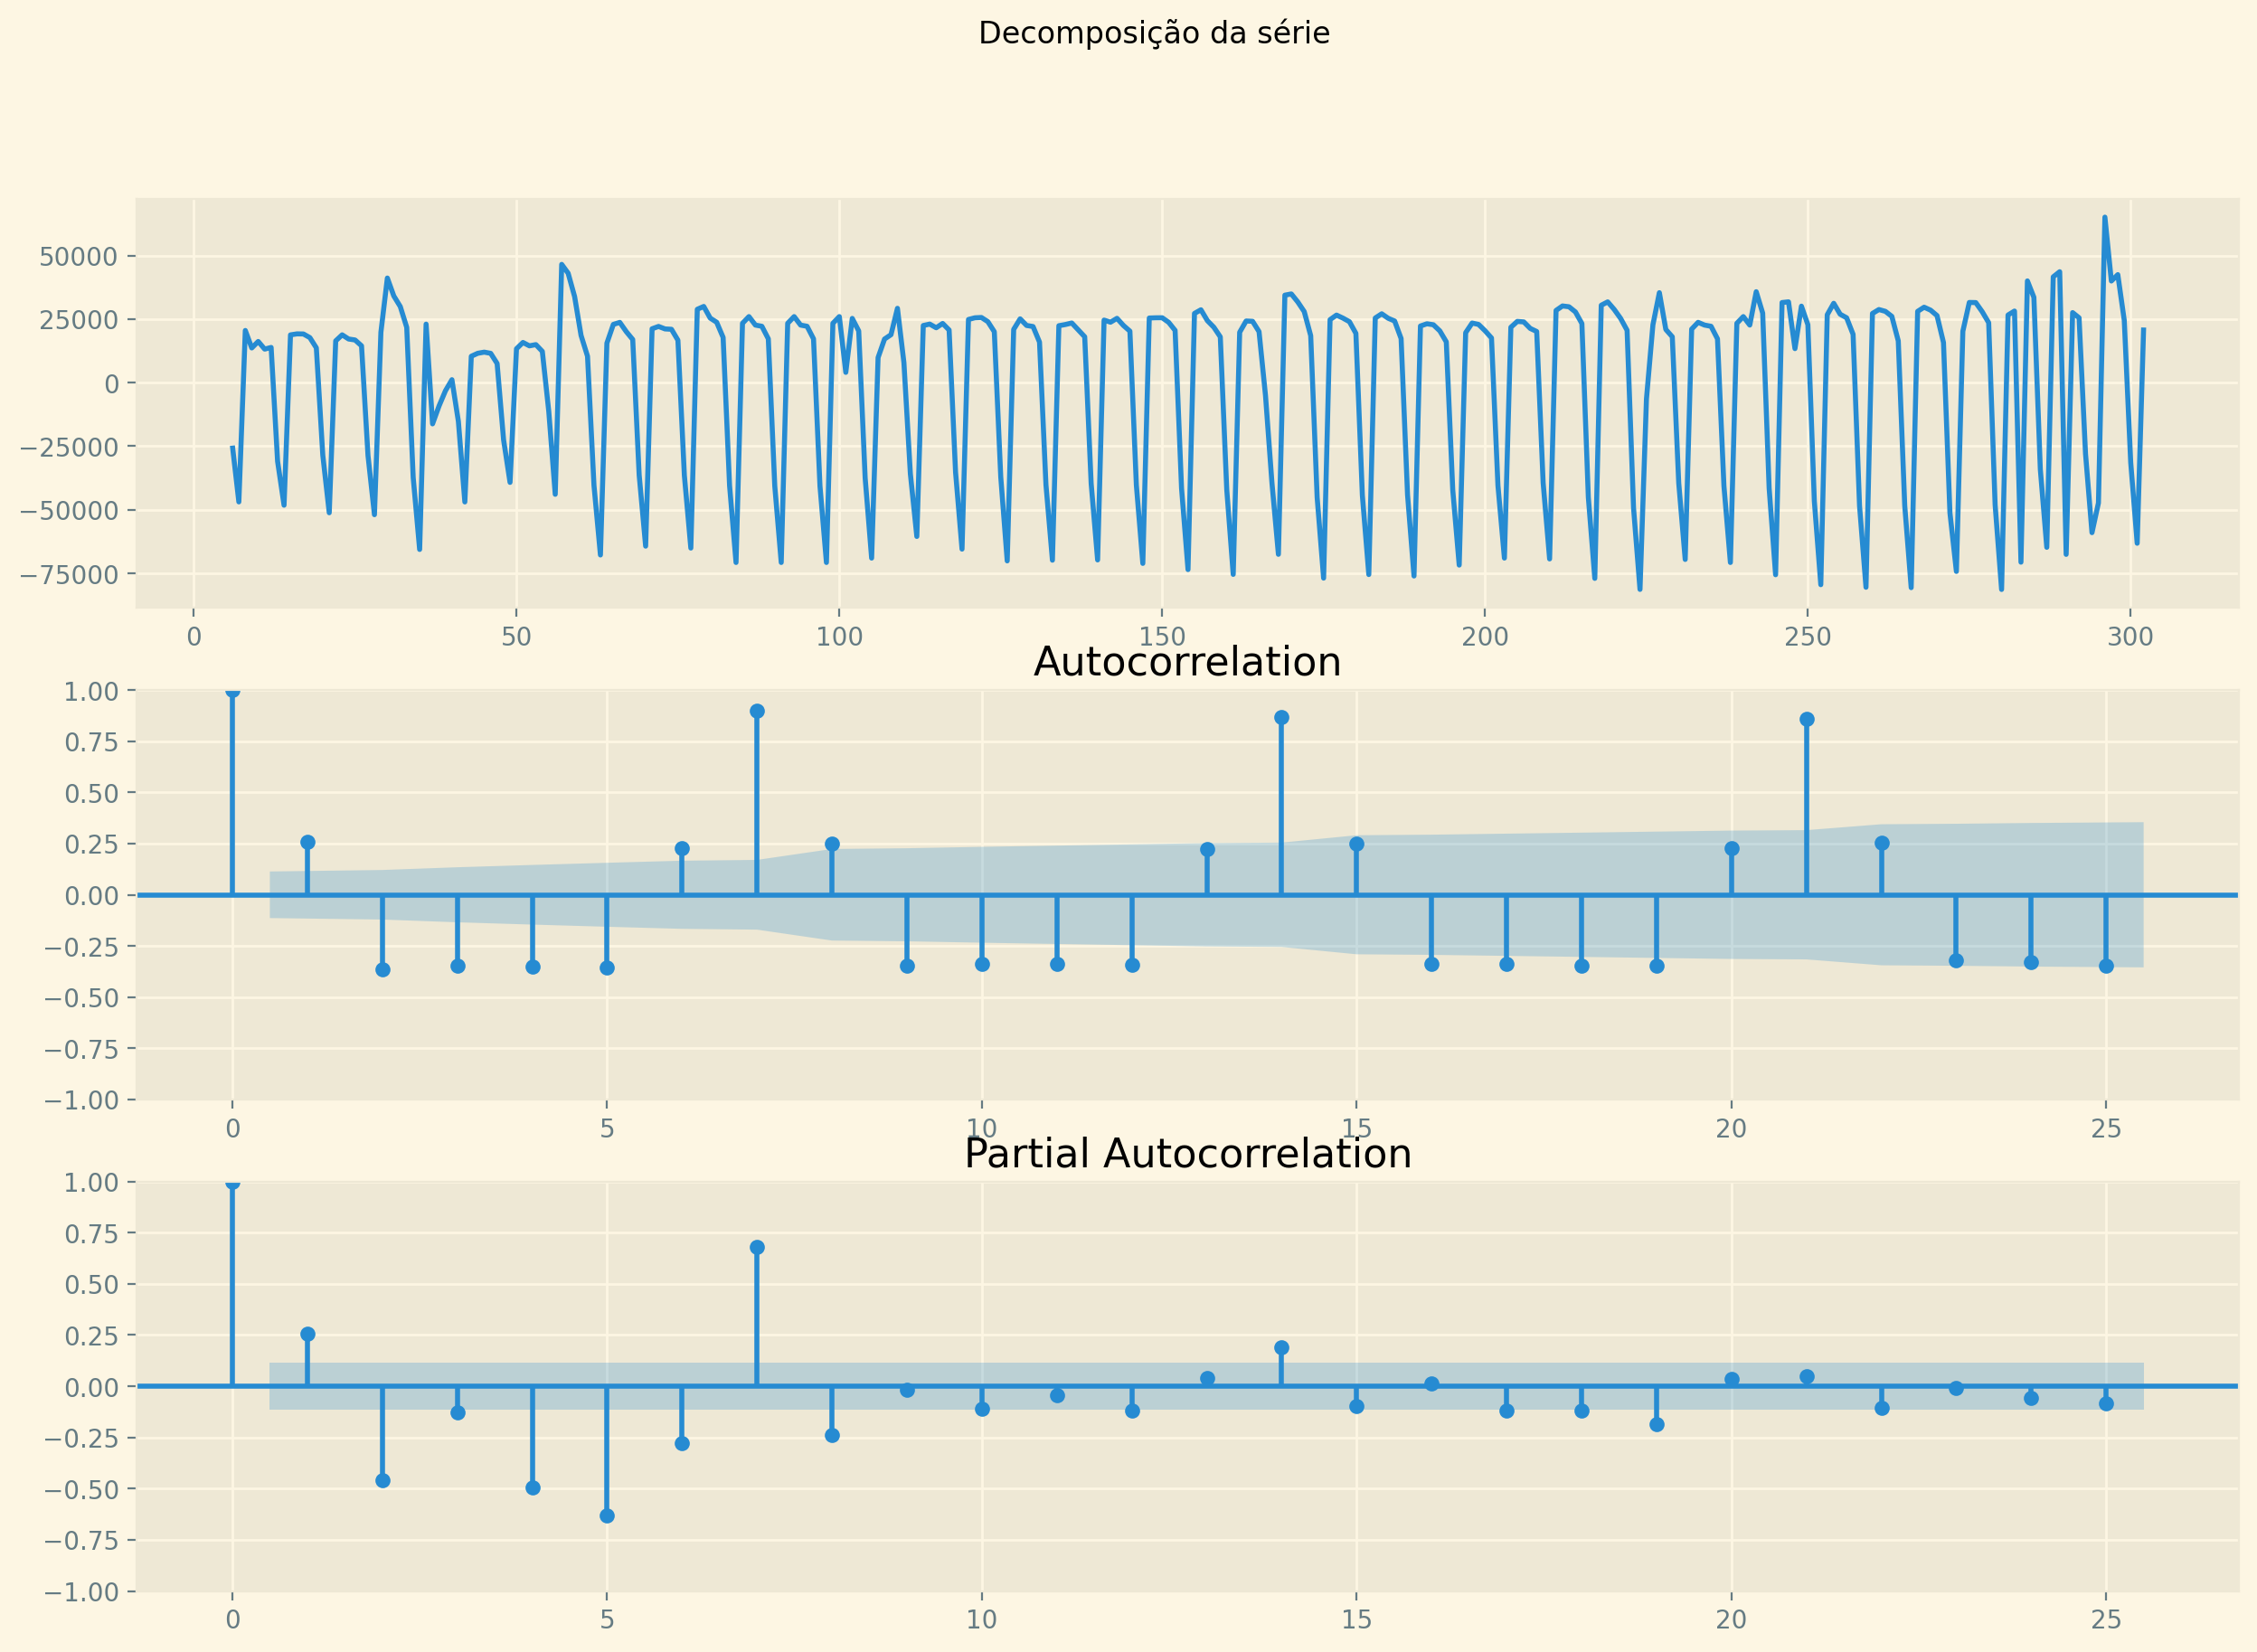

In [26]:
def graficos_series():
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle("Decomposição da série")
    fig.set_size_inches(15,10)
    ax1.plot(list_diff)
    plot_acf(list_diff, ax = ax2)
    plot_pacf(list_diff, ax = ax3)
    plt.show()

graficos_series()

O gráficos não permitem um diagnóstico claro de qual modelos podemos utilizar para séries temporais. Para auxíliar, iremos utilizar a função auto-arima para testar vários modelos e realizamos uma divisão em 90% para treino e 10% para teste, correspondendo ao último mês série histórica utilizada. A mesma divisão será utilizada para Redes Neurais para podermos comparar os resultados.

Abaixo, temos o procedimento de divisão da série aplicação da função auto-arima

In [37]:
data = list_diff
test_size = int(0.102 * len(data))
Y_train, y_test = data[:-test_size], data[-test_size:]
X_train, x_test = np.arange(Y_train.shape[0]), np.arange(Y_train.shape[0], data.shape[0])
X_train.shape, Y_train.shape, y_test.shape, x_test.shape

((267,), (267,), (30,), (30,))

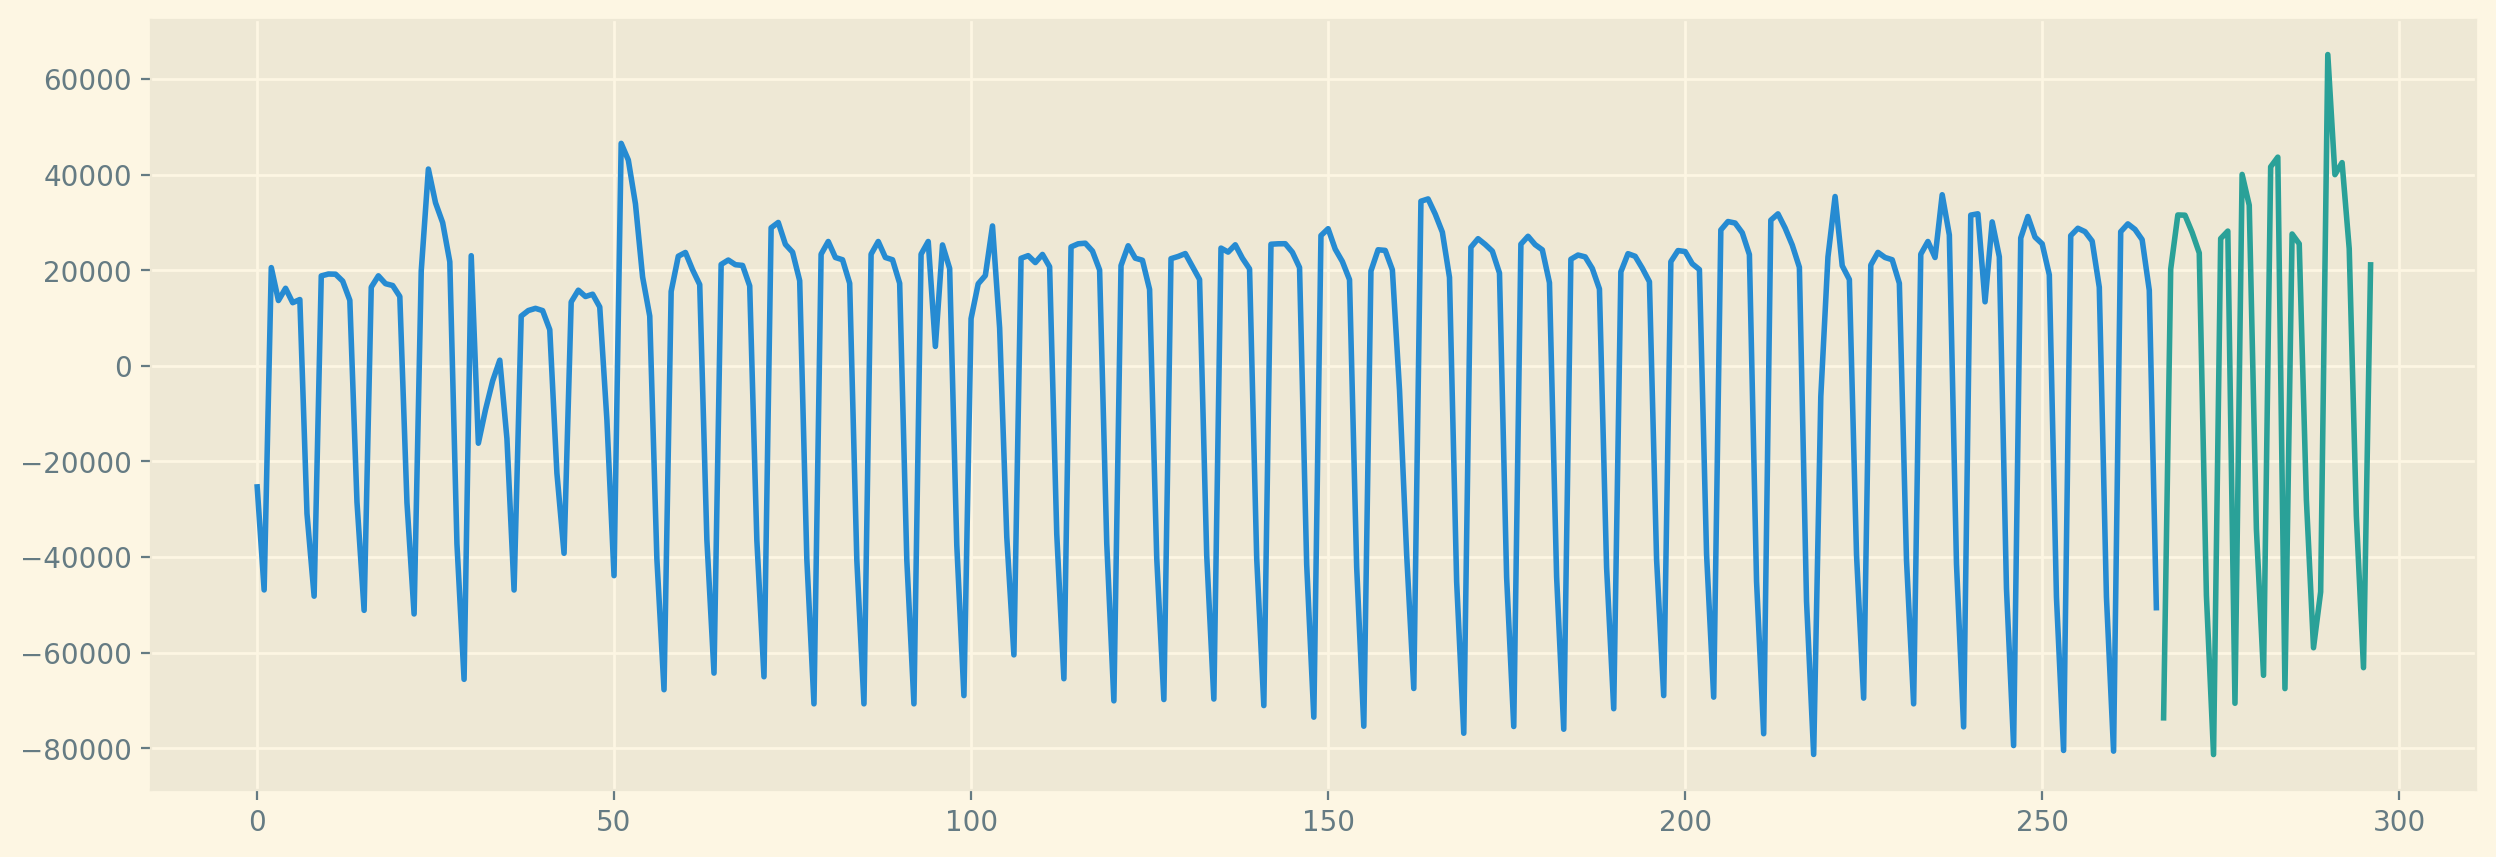

In [38]:
def plot_ts2():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(X_train, Y_train)
    ax.plot(x_test, y_test)

plot_ts2()

In [39]:
model_auto = pm.auto_arima(Y_train, start_p=1, start_q=1,
                    #   exogenous=df[['seasonal_index']],
                      test='adf',
                      max_p=7, max_q=7,
                      m=7,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5497.339, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5444.671, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=5418.696, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=5474.561, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=5419.578, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=5419.687, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=5434.276, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=5421.553, Time=0.51 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=5427.417, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=5427.868, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=5420.745, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]          
T

In [40]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  267
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2706.348
Date:                           Mon, 30 Oct 2023   AIC                           5418.696
Time:                                   15:49:08   BIC                           5429.367
Sample:                                        0   HQIC                          5422.987
                                           - 267                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4264      0.054     -7.906      0.000      -0.532      -0.321
ma.S.L7       -0.5937      0.038    -15.517      0.000      -0.669      -0.519
sigma2      8.936e+07   1.32e-10   6.75e+17      0.000    8.94e+07    8.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.87   Jarque-Bera (JB):               225.72
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+33. Standard errors may be unstable.
"""

No gráfico abaixo temos a comparação com o período de teste e uma medida de avaliação do modelo, utilizaremos o Erro Qudrático Médio

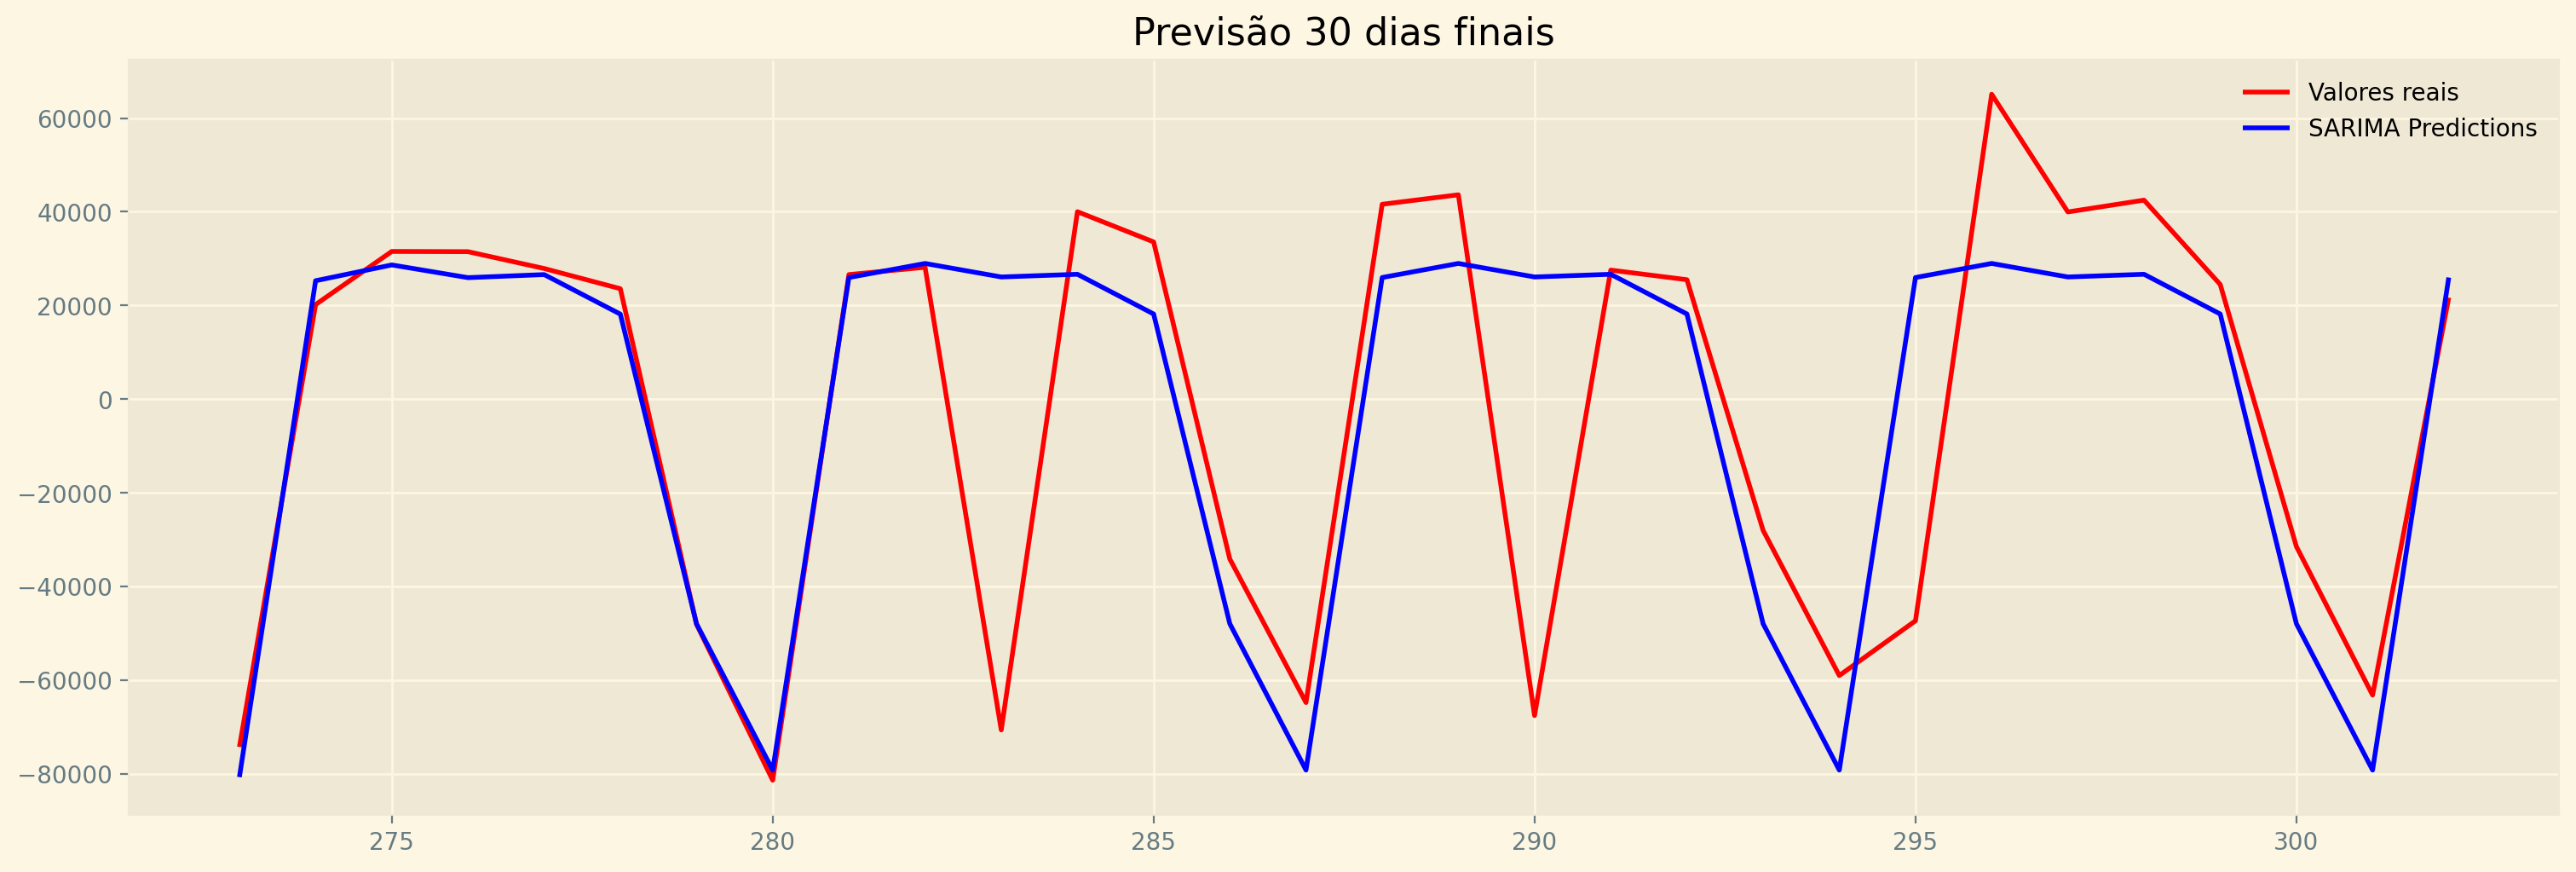

RMSE: 30603.55


In [41]:
model_sarima = SARIMAX(Y_train, model =  model_auto.order, seasonal_order = model_auto.seasonal_order)
model_sarima = model_sarima.fit()


def pred_sarima():
    y_pred = model_sarima.get_forecast(len(y_test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df['Predictions'] = model_sarima.predict(start = y_pred_df.index[0], 
                                                    end = y_pred_df.index[-1])
    y_pred_df.index = y_test.index
    y_pred_out = y_pred_df["Predictions"] 
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    plt.plot(y_test, color = "red", label = 'Valores reais')
    plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
    plt.legend(loc='upper right', frameon=False)
    plt.title('Previsão 30 dias finais')
    plt.show()
    testScore1 = mean_squared_error(y_test, y_pred_out, squared = False)
    print('RMSE: %.2f' % (testScore1))

pred_sarima()


Percebe-se que a série consegue acompanhar bem os valores reais, menos os valores zerados, mas é uma situação esperada. 

Iremos utilizar outro método, mais recente e originado em redes neurais  para comparação

# Rede Neurais

Quando procuramos  criar um modelo de predição para séries temporais, temos uma diferença importante com  base em redes neurais. Não há necessidade de analisar se a série é estacioária. Métodos de deep lerning conseguem trabalhar com dados não-paramétricos o que possibilita a utilização da série sem nenhuma alteração. A única mundança consiste em avaliar dias faltantes devido a greve e criar a linha histórica com dias zerados. 

O maior problema ao utilizar métodos algébricos é na quantidade de opções, o que é um problema bom, mas exigirá mais atenção para encontrar o melhor método. 

Para este trabalho, iremos utilizar LTSM, que consiste numa variação do modelo de Rede Neural, do tipo recorrente e consiste num processo um pouco mais complexo, pois envolve a inclusão de elementos de "memorização" no interior das redes Neurais. Resumidamente, elementos de aproveitamento e descarte de informações são incluídas no interior da Rede Neural para aprendizagem da sequência em análise, como um série temporal. Para a construção do algoritmo utilizamos Pytorch.

Segue abaixo:

In [42]:
# Selecting the 'Passageiros' column and setting the lookback period
freq_pas = freq_pas[['Passageiros']]
lookback = 7

# Deep copy the DataFrame for further manipulation
df = dc(freq_pas)
    
# Create lag features for 'Passageiros'
for i in range(1, lookback+1):
    df[f'Passageiros(t-{i})'] = df['Passageiros'].shift(i)
    
# Remove rows with missing values
df.dropna(inplace=True)

# Scale the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = df.to_numpy()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
print(shifted_df_as_np)

# Define a function to prepare data for LSTM
def prepare_for_lstm(df, lookback, split):

    # Separate features (X) and target (y)
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]

    # Flip the features matrix
    X = dc(np.flip(X, axis=1))

    # Split the data into training and testing sets
    split_index = int(len(df) * split)

    X_train = X[:split_index]
    X_test = X[split_index:]

    y_train = y[:split_index]
    y_test = y[split_index:]

    # Reshape the data for LSTM input
    X_train = X_train.reshape((-1, lookback, 1))
    X_test = X_test.reshape((-1, lookback, 1))

    y_train = y_train.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()

    return X_train, y_train, X_test, y_test

# Define the split ratio
split = 0.88

# Prepare the data for LSTM
X_train, y_train, X_test, y_test = prepare_for_lstm(freq_pas,  lookback, split)

# Print the shapes of the prepared data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


[[-0.96003555 -0.58083915  0.14406012 ...  0.09876362  0.04808331
  -0.9795001 ]
 [ 0.22942461 -0.96003555 -0.58083915 ...  0.08604609  0.09876362
   0.04808331]
 [ 0.1126718   0.22942461 -0.96003555 ...  0.1088065   0.08604609
   0.09876362]
 ...
 [-0.44306877  0.52912349  0.83926214 ... -1.         -0.93114932
  -0.39639181]
 [-1.         -0.44306877  0.52912349 ...  0.94317662 -1.
  -0.93114932]
 [ 0.70815251 -1.         -0.44306877 ...  0.76124863  0.94317662
  -1.        ]]
torch.Size([266, 7, 1]) torch.Size([266, 1]) torch.Size([30, 7, 1]) torch.Size([30, 1])


In [43]:
# requirement of pytorch to use dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)

    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [67]:
# bulding the model 

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    

torch.manual_seed(1612)

model = LSTM(1, 4, 1)

model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [68]:
# code for training

def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f} \n'.format(avg_loss_across_batches))

In [69]:
# Let's go
learning_rate = 0.01
num_epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.669 

Epoch: 2

Val Loss: 0.639 

Epoch: 3

Val Loss: 0.624 

Epoch: 4

Val Loss: 0.582 

Epoch: 5

Val Loss: 0.564 

Epoch: 6

Val Loss: 0.537 

Epoch: 7

Val Loss: 0.509 

Epoch: 8

Val Loss: 0.471 

Epoch: 9

Val Loss: 0.459 

Epoch: 10

Val Loss: 0.440 

Epoch: 11

Val Loss: 0.430 

Epoch: 12

Val Loss: 0.427 

Epoch: 13

Val Loss: 0.435 

Epoch: 14

Val Loss: 0.421 

Epoch: 15

Val Loss: 0.459 

Epoch: 16

Val Loss: 0.415 

Epoch: 17

Val Loss: 0.411 

Epoch: 18

Val Loss: 0.399 

Epoch: 19

Val Loss: 0.416 

Epoch: 20

Val Loss: 0.396 

Epoch: 21

Val Loss: 0.393 

Epoch: 22

Val Loss: 0.397 

Epoch: 23

Val Loss: 0.421 

Epoch: 24

Val Loss: 0.411 

Epoch: 25

Val Loss: 0.408 

Epoch: 26

Val Loss: 0.397 

Epoch: 27

Val Loss: 0.400 

Epoch: 28

Val Loss: 0.408 

Epoch: 29

Val Loss: 0.426 

Epoch: 30

Val Loss: 0.392 

Epoch: 31

Val Loss: 0.404 

Epoch: 32

Val Loss: 0.427 

Epoch: 33

Val Loss: 0.438 

Epoch: 34

Val Loss: 0.439 

Epoch: 35

Val Loss: 0.

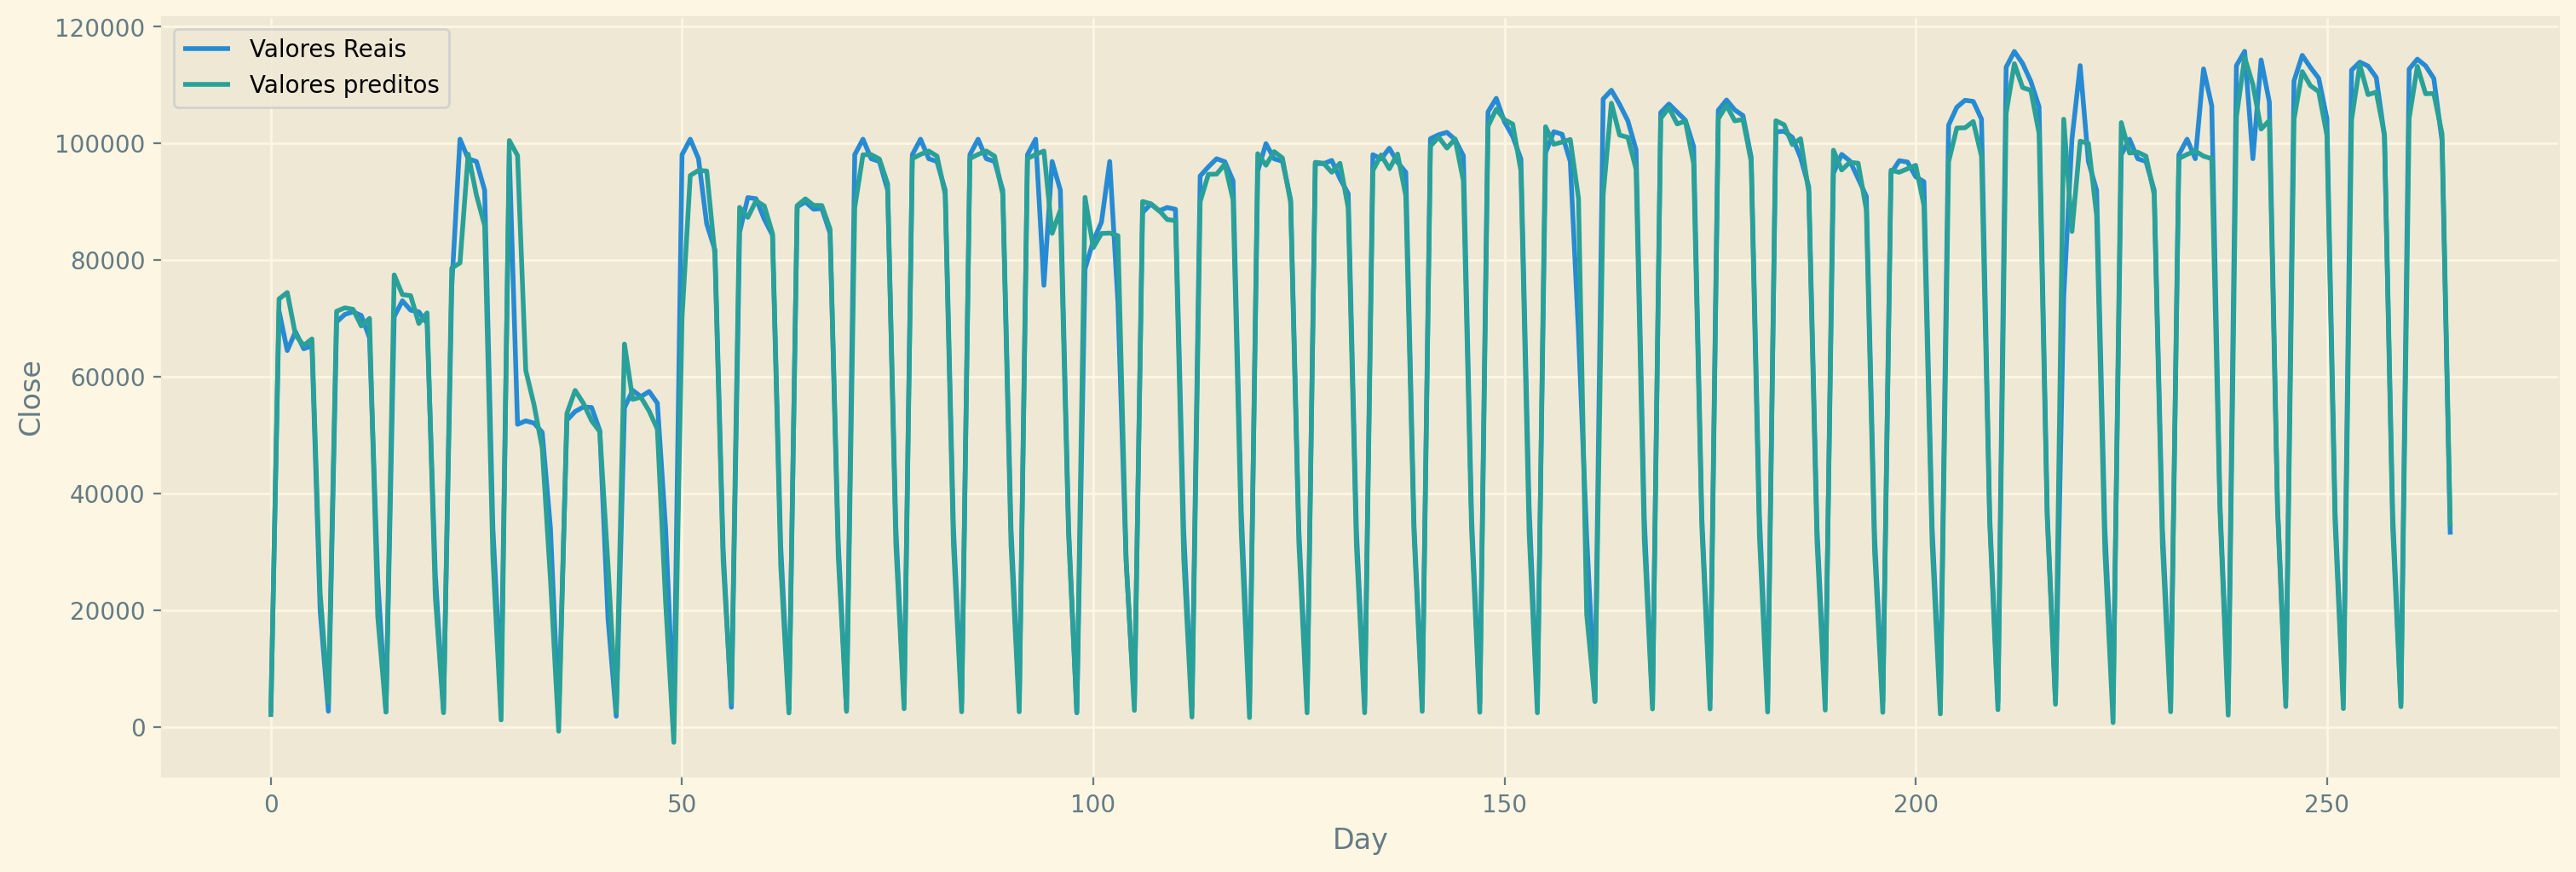

In [74]:
with torch.no_grad():
    predicted = model(X_train).to('cpu').numpy()

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])


fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(15, 5)
plt.plot(new_y_train, label='Valores Reais')
plt.plot(train_predictions, label='Valores preditos')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

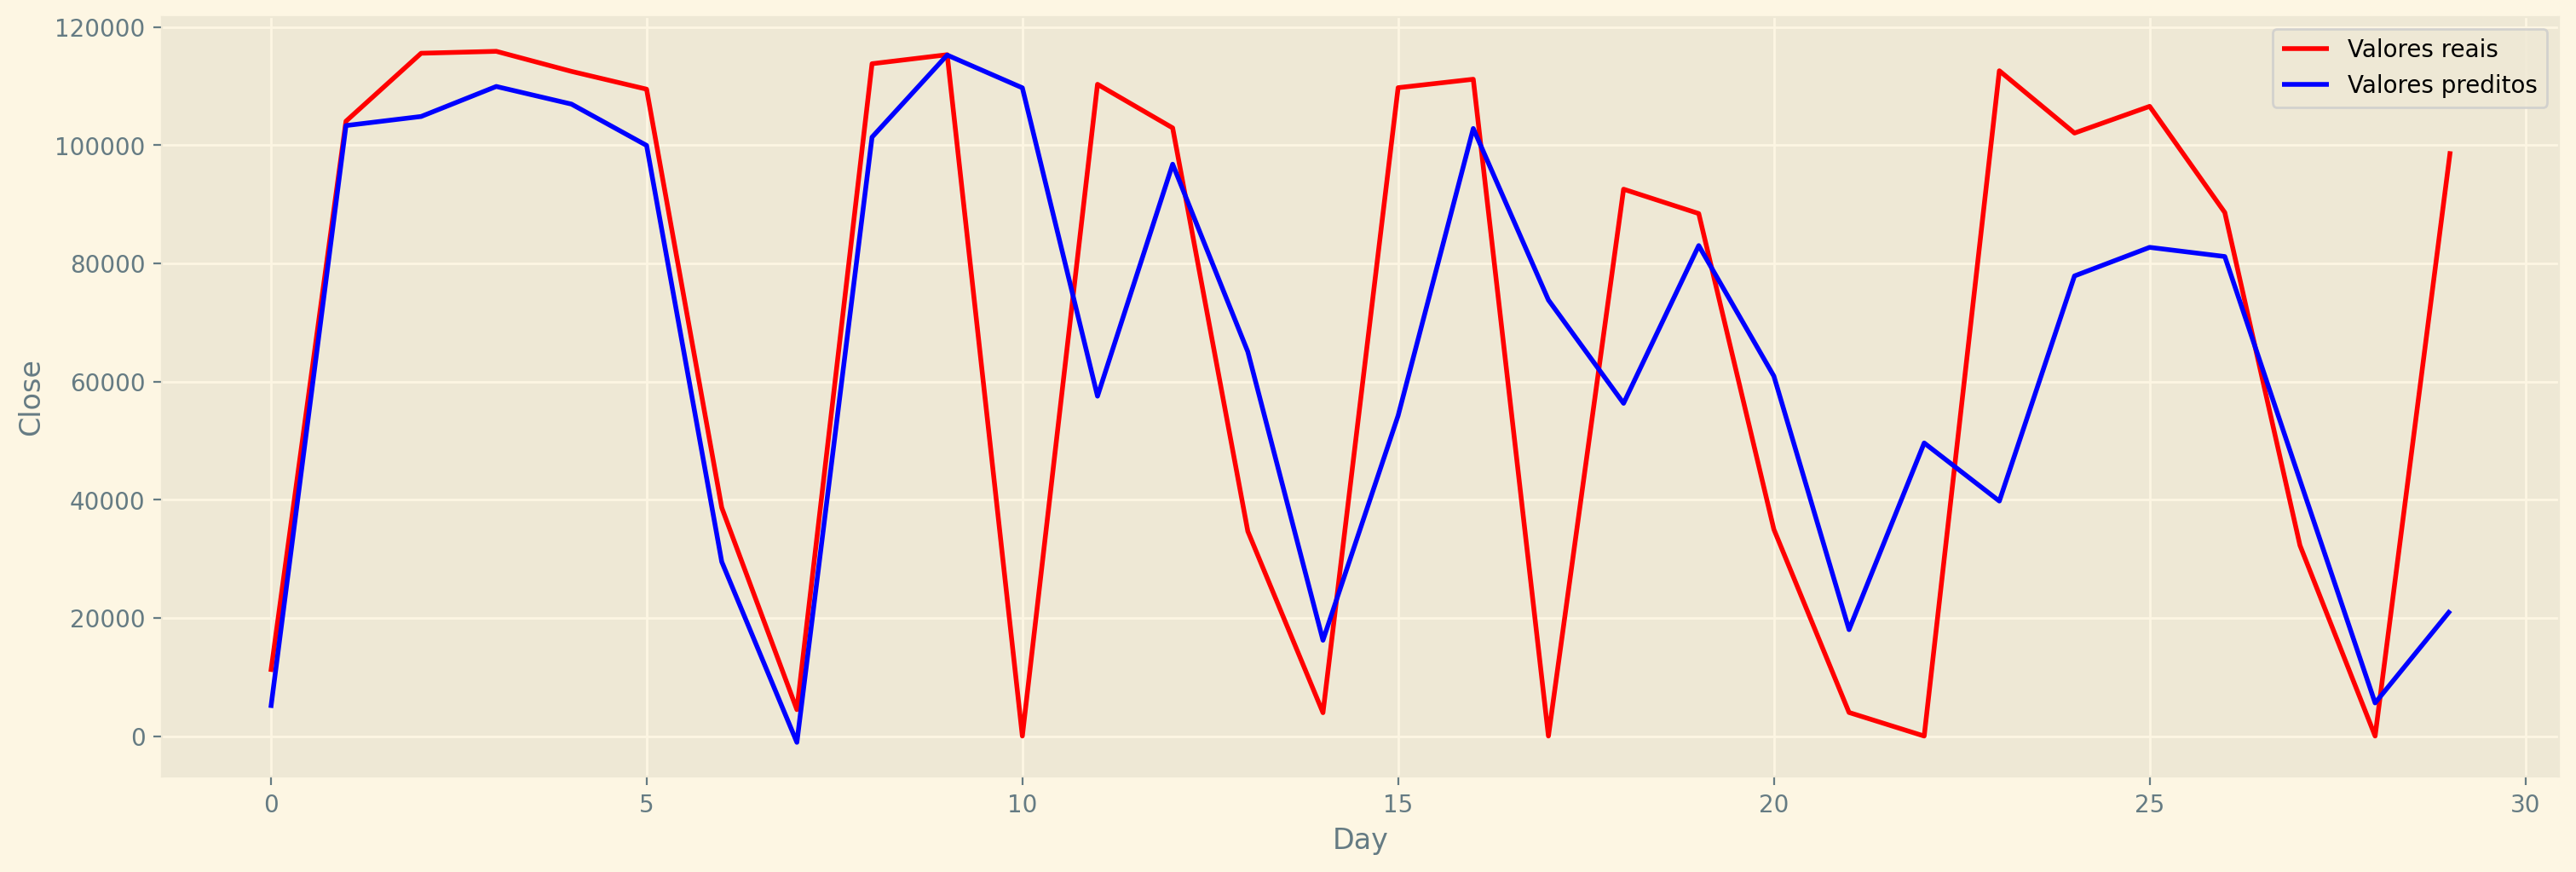

RMSE: 37638.22


In [72]:
test_predictions = model(X_test).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

def pred_lstm():

    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    plt.plot(new_y_test, label='Valores reais', color = "red")
    plt.plot(test_predictions, label='Valores preditos', color='Blue')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

    testScore2 = mean_squared_error(test_predictions, new_y_test, squared = False)
    print('RMSE: %.2f' % (testScore2))

pred_lstm()

## Conclusão 

Após a construção dos modelos, pode-se identificar que o modelo com SARIMA obteve os melhores resultados na predição de valores de treino. Dessa forma, este modelo seria o recomendado para a previsão da quantidade de passageiros. 